폰트설정  
1. 아래 코드 실행  
2. 런타임 다시 시작

In [ ]:
 !sudo apt-get install -y fonts-nanum
 !sudo fc-cache -fv
 !rm ~/.cache/matplotlib -rf

##import

### import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [221]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.1 MB/s eta 0:00:00


In [2]:
pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 71.6 MB/s eta 0:0

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import joblib
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from pycaret import *

### 메소드

In [4]:
def check_holiday(target_df):
  # 주말 여부 확인하여 저장, 주말:true 평일:false
  target_df['holiday'] = target_df['일시'].dt.weekday >= 5

  # 한국의 공휴일 여부 확인하여 저장
  korea_holidays = holidays.KR()
  target_df['공휴일'] = target_df['일시'].apply(lambda x: x in korea_holidays)

  # 공휴일인 경우 holiday 값을 true로 변경
  target_df.loc[target_df['공휴일'], 'holiday'] = True

  return target_df

def make_ymd_feature(target_df):
  # 일시 데이터를 년, 월, 일, 시간으로 나누어 새로운 컬럼 추가
  #target_df['년'] = target_df['일시'].dt.year
  target_df['월'] = target_df['일시'].dt.month
  target_df['일'] = target_df['일시'].dt.day
  target_df['시간'] = target_df['일시'].dt.hour

  return target_df

# 불쾌지수 계산 함수 정의
def calculate_discomfort_index(temperature, humidity):
    return 0.81 * temperature + 0.01 * humidity * (0.99 * temperature - 14.3) + 46.3

# 불쾌지수 이동평균 계산 함수
def calculate_discomfort_moving_average(df):
  df['불쾌지수_이동평균3'] = df.groupby('건물번호')['불쾌지수'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
  df['불쾌지수_이동평균5'] = df.groupby('건물번호')['불쾌지수'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

# smape 계산 함수
def smape_fnc(true, pred):
  v = 2*abs(pred-true)/(abs(pred)+abs(true))
  output=np.mean(v)*100
  return output

def change_date_sin(df):
  # 월, 일, 시간 컬럼에서 각각 값을 가져옴
  month = df['월']
  day = df['일']
  hour = df['시간']

  # 각각의 주기를 설정 (월: 12개, 일: 31개, 시간: 24개)
  max_month = 12
  max_day = 31
  max_hour = 24

  # sin-cos 변환 수식 적용
  #df['월_sin'] = np.sin(2 * np.pi * month / max_month)
  #df['일_sin'] = np.sin(2 * np.pi * day / max_day)
  #df['월_cos'] = np.cos(2 * np.pi * month / max_month)
  #df['일_cos'] = np.cos(2 * np.pi * day / max_day)

  df['시간_sin'] = np.sin(2 * np.pi * hour / max_hour)
  df['시간_cos'] = np.cos(2 * np.pi * hour / max_hour)

# custom metrics
def custom_metrics(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

### 데이터 불러오기

In [214]:
path_drive = '/content/drive/MyDrive/Colab Notebooks/dacon/'
path = '/content/'

In [215]:
train_df = pd.read_csv(path_drive + 'train.csv')
binfo_df = pd.read_csv(path_drive + 'building_info.csv')
test_df = pd.read_csv(path_drive + 'test.csv')

## train 데이터

In [216]:
# 강수량, 일조, 일사 컬럼 삭제
train_df = train_df.drop(columns=['강수량(mm)', '일조(hr)', '일사(MJ/m2)'])

# 풍속과 습도 값이 NaN일 때 전 행의 값으로 치환
train_df['풍속(m/s)'].fillna(method='ffill', inplace=True)
train_df['습도(%)'].fillna(method='ffill', inplace=True)

# 기온 Min-Max 정규화 수행
#scaler = MinMaxScaler()
#train_df[['기온_정규화']] = scaler.fit_transform(train_df[['기온(C)']])

# 불쾌지수 계산 후 새로운 컬럼 추가
train_df['불쾌지수'] = calculate_discomfort_index(train_df['기온(C)'], train_df['습도(%)'])

# 불쾌지수 이동평균 (3, 5) 계산 후 컬럼 추가
calculate_discomfort_moving_average(train_df)

# '일시' 열을 날짜 형식으로 변환
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
train_df = check_holiday(train_df)

# 년, 월, 일, 시간 컬럼 추가
train_df = make_ymd_feature(train_df)

# 월, 일, 시간 sin 값으로 바꾼 후 컬럼 추가
change_date_sin(train_df)

# 요일 컬럼 추가
train_df['요일'] = train_df['일시'].dt.dayofweek  # 요일을 0(월요일)부터 6(일요일)까지의 정수로 저장

# 컬럼 삭제
train_df.drop(columns=['num_date_time','공휴일'], inplace=True) # '일시'

# csv 파일로 저장
#train_df.to_csv('train_p.csv', index=False)

train_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,일,시간,시간_sin,시간_cos,요일
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,6,1,0,0.000000,1.000000,2
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,6,1,1,0.258819,0.965926,2
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,6,1,2,0.500000,0.866025,2
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,6,1,3,0.707107,0.707107,2
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,6,1,4,0.866025,0.500000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,8,24,19,-0.965926,0.258819,2
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,8,24,20,-0.866025,0.500000,2
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,8,24,21,-0.707107,0.707107,2
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,8,24,22,-0.500000,0.866025,2


In [217]:
train_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일']

## buliding_info 데이터

In [218]:
#  '-'인 경우 0으로 대체
binfo_df = binfo_df.replace('-', 0)

# 건물유형 원-핫 인코딩
one_hot_encoded = pd.get_dummies(binfo_df['건물유형'])
binfo_df = pd.concat([binfo_df, one_hot_encoded], axis=1)

# 라벨 인코더 생성 및 적용
label_encoder = LabelEncoder()
binfo_df['건물유형_라벨'] = label_encoder.fit_transform(binfo_df['건물유형'])+1

# 문자열을 숫자로 변환
binfo_df['태양광용량(kW)'] = binfo_df['태양광용량(kW)'].astype(float)
binfo_df['ESS저장용량(kWh)'] = binfo_df['ESS저장용량(kWh)'].astype(float)
binfo_df['PCS용량(kW)'] = binfo_df['PCS용량(kW)'].astype(float)

#로그변환
binfo_df['연면적(m2)'] = binfo_df['연면적(m2)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['냉방면적(m2)'] = binfo_df['냉방면적(m2)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['태양광용량(kW)'] = binfo_df['태양광용량(kW)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['ESS저장용량(kWh)'] = binfo_df['ESS저장용량(kWh)'].map(lambda x:np.log(x) if x > 0 else 0)
binfo_df['PCS용량(kW)'] = binfo_df['PCS용량(kW)'].map(lambda x:np.log(x) if x > 0 else 0)

# 컬럼 삭제
binfo_df.drop(columns=['PCS용량(kW)'], inplace=True)

#태양광 여부 컬럼 추가
binfo_df['태양광여부'] = binfo_df['태양광용량(kW)'] != 0


# csv 파일로 저장
#df.to_csv('building_info_p.csv', index=False)

binfo_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,공공,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,건물기타,110634.00,39570.00,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,False
1,2,건물기타,122233.47,99000.00,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,False
2,3,건물기타,171243.00,113950.00,40.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,True
3,4,건물기타,74312.98,34419.62,60.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,True
4,5,건물기타,205884.00,150000.00,0.0,2557.0,1,0,0,0,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False
96,97,호텔및리조트,55144.67,25880.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False
97,98,호텔및리조트,53578.62,17373.75,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False
98,99,호텔및리조트,53499.00,40636.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,12,False


In [219]:
sorted_df = binfo_df.sort_values(by='냉방면적(m2)')
sorted_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,공공,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
65,66,아파트,1.050730e+05,0.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
67,68,아파트,3.893959e+05,0.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
64,65,아파트,1.838390e+05,0.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False
76,77,지식산업센터,6.737714e+04,1.00,0.00,0.0,0,0,0,0,0,0,0,0,0,1,0,0,10,False
79,80,지식산업센터,2.563702e+05,239.00,0.00,0.0,0,0,0,0,0,0,0,0,0,1,0,0,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,25,대학교,5.280141e+05,369812.24,50.00,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
26,27,대학교,5.784841e+05,501381.53,30.00,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
23,24,대학교,6.596969e+05,516097.85,97.65,0.0,0,0,1,0,0,0,0,0,0,0,0,0,3,True
60,61,아파트,6.671310e+05,539213.00,0.00,0.0,0,0,0,0,0,0,0,1,0,0,0,0,8,False


In [220]:
binfo_df.columns.tolist()

['건물번호',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

## test 데이터

In [59]:

# 기온 Min-Max 정규화 수행
#scaler = MinMaxScaler()
#df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# 불쾌지수 계산 후 새로운 컬럼 추가
test_df['불쾌지수'] = calculate_discomfort_index(test_df['기온(C)'], test_df['습도(%)'])

# 불쾌지수 이동평균 (3, 5) 계산 후 컬럼 추가
calculate_discomfort_moving_average(test_df)

# '일시' 열을 날짜 형식으로 변환
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
test_df = check_holiday(test_df)

# 월, 일, 시간 컬럼 추가
test_df = make_ymd_feature(test_df)

# 월, 일, 시간 sin 값으로 바꾼 후 컬럼 추가
change_date_sin(test_df)

# 요일 컬럼 추가
test_df['요일'] = test_df['일시'].dt.dayofweek  # 요일을 0(월요일)부터 6(일요일)까지의 정수로 저장

# 건물번호로 binfo_df 연결 (left join)
test_df = pd.merge(test_df, binfo_df, on='건물번호', how='left')

# 컬럼 삭제
test_df.drop(columns=['num_date_time','강수량(mm)', '공휴일', '건물유형'], inplace=True) #'건물번호',

# csv 파일로 저장
#test_df.to_csv('test_p.csv', index=False)

test_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,...,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,2022-08-25 00:00:00,23.5,2.2,72,71.78980,71.789800,71.789800,False,8,...,0,0,0,0,0,0,0,0,1,False
1,1,2022-08-25 01:00:00,23.0,0.9,72,71.02840,71.409100,71.409100,False,8,...,0,0,0,0,0,0,0,0,1,False
2,1,2022-08-25 02:00:00,22.7,1.5,75,70.81675,71.211650,71.211650,False,8,...,0,0,0,0,0,0,0,0,1,False
3,1,2022-08-25 03:00:00,22.1,1.3,78,70.11262,70.652590,70.936892,False,8,...,0,0,0,0,0,0,0,0,1,False
4,1,2022-08-25 04:00:00,21.8,1.0,77,69.56514,70.164837,70.662542,False,8,...,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.9,84,71.22400,72.378973,72.792244,False,8,...,0,0,0,0,0,0,0,1,12,False
16796,100,2022-08-31 20:00:00,20.7,0.4,95,68.95035,70.961363,71.899884,False,8,...,0,0,0,0,0,0,0,1,12,False
16797,100,2022-08-31 21:00:00,20.2,0.4,98,68.24604,69.473463,70.866662,False,8,...,0,0,0,0,0,0,0,1,12,False
16798,100,2022-08-31 22:00:00,20.1,1.1,97,68.01203,68.402807,69.828432,False,8,...,0,0,0,0,0,0,0,1,12,False


In [60]:
test_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

## combined 데이터

In [61]:
# 건물번호로 train_df와 binfo_df 연결 (left join)
combined_df = pd.merge(train_df, binfo_df, on='건물번호', how='left')

combined_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,0,0,0,0,1,False
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,0,0,0,0,1,False
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,0,0,0,0,1,False
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,0,0,0,0,1,False
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,0,0,0,0,1,12,False
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,0,0,0,0,1,12,False
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,0,0,0,0,1,12,False
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,0,0,0,0,1,12,False


In [62]:
combined_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부']

In [63]:

combined_df.to_csv(path+'combined_df.csv', index=False)

## 변수 추가

In [64]:
combined_df['work_time'] = 0
combined_df['low_day'] = 0
combined_df['particular'] = 0

trains = [combined_df[combined_df['건물번호'] == num] for num in range(1,101,1)]
# aa = trains[9]
# aa['work_time']  = (aa['시간'].isin([6,7,8])).astype(int)
# aa.describe()

## cluster 0
for num in [10,13]:
    temp_df = trains[num-1]
    temp_df['work_time'] = (temp_df['시간'].isin([6,7,8])).astype(int)

    trains[num-1] = temp_df
for num in [14]:
    temp_df = trains[num-1]
    temp_df['work_time'] = (temp_df['시간'].isin([6,7])).astype(int)
    temp_df['particular'] = temp_df['시간'].isin([0,8,12,18]).astype(int)
    trains[num-1] = temp_df
for num in [15]:
    temp_df = trains[num-1]
    temp_df['work_time'] = (temp_df['시간'].isin([4,5,6,7,8])).astype(int)
    trains[num-1] = temp_df

## cluster 1
for num in [17,18,19,21,22,69,70,72]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [45,46,47,48,49,51,52,73]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [26,28,76,78,80,82,83,84]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=8)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [71]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)*(temp_df['시간']>=8)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    temp_df['particular'] = (((temp_df['요일']==5)&(temp_df['시간'].isin([10,11,13,14])))
                               |((temp_df['요일'].isin([0,1,2,3,4,5]))&(temp_df['시간'].isin([0,1,2,3,4])))).astype(int)
    trains[num-1] = temp_df
for num in [53]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=4)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [55]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=19)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [50]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [56]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    temp_df['particular'] = ((temp_df['요일']==2)&(temp_df['시간']==16)).astype(int)
    trains[num-1] = temp_df
for num in [60]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [20,23]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=17)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [58,59,77]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [45,46,47,48,49,51,52,73]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [27,74,79]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=7)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [57]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=7)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [24,25]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=8)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [29,30]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=17)&(temp_df['시간']>=9)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [31]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=9)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    trains[num-1] = temp_df
for num in [50]:
    temp_df = trains[num-1]
    temp_df['particular'] = (((temp_df['요일']==2)&(temp_df['시간']==16))|((temp_df['요일']==2)&(temp_df['시간']==16))).astype(int)
    trains[num-1] = temp_df
for num in [1]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=7)).astype(int)
    temp_df['low_day'] = (temp_df['요일']==6).astype(int)
    trains[num-1] = temp_df
for num in [8]:
    temp_df = trains[num-1]
    temp_df['low_day'] = (temp_df['요일']==6).astype(int)
    trains[num-1] = temp_df
for num in [12]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일']==6).astype(int)
    trains[num-1] = temp_df
for num in [88,90]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=8)).astype(int)
    trains[num-1] = temp_df
for num in [86]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=8)).astype(int)
    temp_df['particular'] = ((temp_df['월']==6)&(temp_df['일']==26)).astype(int)
    trains[num-1] = temp_df
for num in [87,89,91]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=9)).astype(int)
    trains[num-1] = temp_df
for num in [4]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=8)).astype(int)
    trains[num-1] = temp_df
for num in [7,16]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=5)).astype(int)
    trains[num-1] = temp_df
for num in [9]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=23)&(temp_df['시간']>=7)).astype(int)
    trains[num-1] = temp_df
for num in [11]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=7)).astype(int)
    trains[num-1] = temp_df
for num in [36]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=9)).astype(int)
    trains[num-1] = temp_df
for num in [75]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=15)&(temp_df['시간']>=7)).astype(int)
    trains[num-1] = temp_df
for num in [92]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=6)).astype(int)
    trains[num-1] = temp_df

## cluster 2
for num in [32,33,34]:
    temp_df = trains[num-1]
    temp_df = temp_df[temp_df.월>=7]
    trains[num-1] = temp_df
for num in [61,65,66,67,68]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=7)&(temp_df['시간']<=23)).astype(int)
    trains[num-1] = temp_df
for num in [62,63,64]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=23)).astype(int)
    trains[num-1] = temp_df

## cluster 3
for num in [93,94,96,97,98,100]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=6)&(temp_df['시간']<=22)).astype(int)
    trains[num-1] = temp_df
for num in [42,43,44]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=9)&(temp_df['시간']<=20)).astype(int)
    trains[num-1] = temp_df
for num in [2,85,99]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=21)).astype(int)
    trains[num-1] = temp_df
for num in [38,40,95]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=20)).astype(int)
    trains[num-1] = temp_df
for num in [3,81]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=9)&(temp_df['시간']<=21)).astype(int)
    trains[num-1] = temp_df
for num in [6,41]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=22)).astype(int)
    trains[num-1] = temp_df
for num in [37,39]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=7)&(temp_df['시간']<=21)).astype(int)
    trains[num-1] = temp_df
for num in [35]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=7)&(temp_df['시간']<=23)).astype(int)
    trains[num-1] = temp_df
for num in [54]:
    temp_df = trains[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=5)&(temp_df['시간']<=20)).astype(int)
    temp_df['low_day'] = (temp_df['요일']==0).astype(int)
    trains[num-1] = temp_df
for num in [5]:
    temp_df = trains[num-1]
    temp_df['particular'] = (((temp_df['요일']==4)&(temp_df['시간'].isin([11,12,13,14,15,16,17,18,19,20])))|
                              ((temp_df['요일']==5)&(temp_df['시간'].isin([11,12,13,14,15,16,17,18,19,20])))|
                              ((temp_df['요일']==6)&(temp_df['시간'].isin([8,9,10,11,12,13,14,15,16,17,18])))).astype(int)
    trains[num-1] = temp_df

In [65]:
combined_df = pd.concat(trains, ignore_index=True)
combined_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,work_time,low_day,particular
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,0,1,False,0,0,0
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,0,1,False,0,0,0
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,0,1,False,0,0,0
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,0,1,False,0,0,0
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,0,1,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201835,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,0,1,12,False,1,0,0
201836,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,0,1,12,False,1,0,0
201837,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,0,1,12,False,1,0,0
201838,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,0,1,12,False,1,0,0


In [66]:
combined_clust_df.describe()

,건물번호,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,월,일,...,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,work_time,low_day,particular,km_cluster
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,...,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.0,204000.0,204000.0,204000.000000
mean,50.500000,25.543524,2.134052,78.716518,2451.036462,75.419692,75.415600,75.410946,6.929412,14.835294,...,0.080000,0.080000,0.080000,0.080000,0.080000,6.190000,0.0,0.0,0.0,1.380000
std,28.866141,3.779523,1.358146,15.080496,2440.648858,5.460597,5.422127,5.366819,0.793923,8.446178,...,0.271294,0.271294,0.271294,0.271294,0.271294,3.643345,0.0,0.0,0.0,1.286704
min,1.000000,10.100000,0.000000,13.000000,0.000000,50.481070,51.276703,51.735894,6.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000
25%,25.750000,23.400000,1.200000,69.000000,1085.760000,72.551720,72.572380,72.620498,6.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.0,0.0,0.0,0.000000
50%,50.500000,25.700000,2.000000,81.000000,1766.400000,76.268500,76.291660,76.306130,7.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.0,0.0,0.0,1.000000
75%,75.250000,28.100000,2.800000,91.000000,2970.000000,79.366630,79.339183,79.304482,8.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.0,0.0,0.0,3.000000
max,100.000000,37.100000,13.300000,100.000000,25488.400000,87.789790,87.330393,87.210598,8.000000,31.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,0.0,0.0,0.0,3.000000


In [67]:
test_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,...,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부
0,1,2022-08-25 00:00:00,23.5,2.2,72,71.78980,71.789800,71.789800,False,8,...,0,0,0,0,0,0,0,0,1,False
1,1,2022-08-25 01:00:00,23.0,0.9,72,71.02840,71.409100,71.409100,False,8,...,0,0,0,0,0,0,0,0,1,False
2,1,2022-08-25 02:00:00,22.7,1.5,75,70.81675,71.211650,71.211650,False,8,...,0,0,0,0,0,0,0,0,1,False
3,1,2022-08-25 03:00:00,22.1,1.3,78,70.11262,70.652590,70.936892,False,8,...,0,0,0,0,0,0,0,0,1,False
4,1,2022-08-25 04:00:00,21.8,1.0,77,69.56514,70.164837,70.662542,False,8,...,0,0,0,0,0,0,0,0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.9,84,71.22400,72.378973,72.792244,False,8,...,0,0,0,0,0,0,0,1,12,False
16796,100,2022-08-31 20:00:00,20.7,0.4,95,68.95035,70.961363,71.899884,False,8,...,0,0,0,0,0,0,0,1,12,False
16797,100,2022-08-31 21:00:00,20.2,0.4,98,68.24604,69.473463,70.866662,False,8,...,0,0,0,0,0,0,0,1,12,False
16798,100,2022-08-31 22:00:00,20.1,1.1,97,68.01203,68.402807,69.828432,False,8,...,0,0,0,0,0,0,0,1,12,False


In [68]:
test_df['work_time'] = 0
test_df['low_day'] = 0
test_df['particular'] = 0
tests = [test_df[test_df['건물번호'] == num] for num in range(1,101,1)]
# aa = tests[9]
# aa['work_time']  = (aa['시간'].isin([6,7,8])).astype(int)
# aa.describe()

## cluster 0
for num in [10,13]:
    temp_df = tests[num-1]
    temp_df['work_time'] = (temp_df['시간'].isin([6,7,8])).astype(int)

    tests[num-1] = temp_df
for num in [14]:
    temp_df = tests[num-1]
    temp_df['work_time'] = (temp_df['시간'].isin([6,7])).astype(int)
    temp_df['particular'] = temp_df['시간'].isin([0,8,12,18]).astype(int)
    tests[num-1] = temp_df
for num in [15]:
    temp_df = tests[num-1]
    temp_df['work_time'] = (temp_df['시간'].isin([4,5,6,7,8])).astype(int)
    tests[num-1] = temp_df

## cluster 1
for num in [17,18,19,21,22,69,70,72]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [45,46,47,48,49,51,52,73]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [26,28,76,78,80,82,83,84]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=8)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [71]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)*(temp_df['시간']>=8)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    temp_df['particular'] = (((temp_df['요일']==5)&(temp_df['시간'].isin([10,11,13,14])))
                               |((temp_df['요일'].isin([0,1,2,3,4,5]))&(temp_df['시간'].isin([0,1,2,3,4])))).astype(int)
    tests[num-1] = temp_df
for num in [53]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=4)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [55]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=19)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [50]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [56]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    temp_df['particular'] = ((temp_df['요일']==2)&(temp_df['시간']==16)).astype(int)
    tests[num-1] = temp_df
for num in [60]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [20,23]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=17)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [58,59,77]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [45,46,47,48,49,51,52,73]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=6)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [27,74,79]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=7)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [57]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=7)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [24,25]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=8)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [29,30]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=17)&(temp_df['시간']>=9)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [31]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=9)).astype(int)
    temp_df['low_day'] = (temp_df['요일'].isin([5,6])).astype(int)
    tests[num-1] = temp_df
for num in [50]:
    temp_df = tests[num-1]
    temp_df['particular'] = (((temp_df['요일']==2)&(temp_df['시간']==16))|((temp_df['요일']==2)&(temp_df['시간']==16))).astype(int)
    tests[num-1] = temp_df
for num in [1]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=7)).astype(int)
    temp_df['low_day'] = (temp_df['요일']==6).astype(int)
    tests[num-1] = temp_df
for num in [8]:
    temp_df = tests[num-1]
    temp_df['low_day'] = (temp_df['요일']==6).astype(int)
    tests[num-1] = temp_df
for num in [12]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=5)).astype(int)
    temp_df['low_day'] = (temp_df['요일']==6).astype(int)
    tests[num-1] = temp_df
for num in [88,90]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=8)).astype(int)
    tests[num-1] = temp_df
for num in [86]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=8)).astype(int)
    temp_df['particular'] = ((temp_df['월']==6)&(temp_df['일']==26)).astype(int)
    tests[num-1] = temp_df
for num in [87,89,91]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=9)).astype(int)
    tests[num-1] = temp_df
for num in [4]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=18)&(temp_df['시간']>=8)).astype(int)
    tests[num-1] = temp_df
for num in [7,16]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=5)).astype(int)
    tests[num-1] = temp_df
for num in [9]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=23)&(temp_df['시간']>=7)).astype(int)
    tests[num-1] = temp_df
for num in [11]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=21)&(temp_df['시간']>=7)).astype(int)
    tests[num-1] = temp_df
for num in [36]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=20)&(temp_df['시간']>=9)).astype(int)
    tests[num-1] = temp_df
for num in [75]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=15)&(temp_df['시간']>=7)).astype(int)
    tests[num-1] = temp_df
for num in [92]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']<=22)&(temp_df['시간']>=6)).astype(int)
    tests[num-1] = temp_df

## cluster 2
for num in [32,33,34]:
    temp_df = tests[num-1]
    temp_df = temp_df[temp_df.월>=7]
    tests[num-1] = temp_df
for num in [61,65,66,67,68]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=7)&(temp_df['시간']<=23)).astype(int)
    tests[num-1] = temp_df
for num in [62,63,64]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=23)).astype(int)
    tests[num-1] = temp_df

## cluster 3
for num in [93,94,96,97,98,100]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=6)&(temp_df['시간']<=22)).astype(int)
    tests[num-1] = temp_df
for num in [42,43,44]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=9)&(temp_df['시간']<=20)).astype(int)
    tests[num-1] = temp_df
for num in [2,85,99]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=21)).astype(int)
    tests[num-1] = temp_df
for num in [38,40,95]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=20)).astype(int)
    tests[num-1] = temp_df
for num in [3,81]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=9)&(temp_df['시간']<=21)).astype(int)
    tests[num-1] = temp_df
for num in [6,41]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=8)&(temp_df['시간']<=22)).astype(int)
    tests[num-1] = temp_df
for num in [37,39]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=7)&(temp_df['시간']<=21)).astype(int)
    tests[num-1] = temp_df
for num in [35]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=7)&(temp_df['시간']<=23)).astype(int)
    tests[num-1] = temp_df
for num in [54]:
    temp_df = tests[num-1]
    temp_df['work_time'] = ((temp_df['시간']>=5)&(temp_df['시간']<=20)).astype(int)
    temp_df['low_day'] = (temp_df['요일']==0).astype(int)
    tests[num-1] = temp_df
for num in [5]:
    temp_df = tests[num-1]
    temp_df['particular'] = (((temp_df['요일']==4)&(temp_df['시간'].isin([11,12,13,14,15,16,17,18,19,20])))|
                              ((temp_df['요일']==5)&(temp_df['시간'].isin([11,12,13,14,15,16,17,18,19,20])))|
                              ((temp_df['요일']==6)&(temp_df['시간'].isin([8,9,10,11,12,13,14,15,16,17,18])))).astype(int)
    tests[num-1] = temp_df


df = pd.concat(tests, ignore_index=True)

## 군집화 수행

In [69]:
combined_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'work_time',
 'low_day',
 'particular']

요일별 시간별 데이터프레임 생성

In [70]:
# 건물을 기준으로 하는 data frame 생성
by_weekday = combined_df.groupby(['건물유형_라벨','요일'])['전력소비량(kWh)'].median().reset_index().pivot('건물유형_라벨','요일','전력소비량(kWh)').reset_index()
by_hour = combined_df.groupby(['건물유형_라벨','시간'])['전력소비량(kWh)'].median().reset_index().pivot('건물유형_라벨','시간','전력소비량(kWh)').reset_index().drop('건물유형_라벨', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['건물유형_라벨'] + ['day'+str(i) for i in range(7)] + ['hour'+str(i) for i in range(24)]
df.columns = columns

In [71]:
by_weekday

요일,건물유형_라벨,0,1,2,3,4,5,6
0,1,1631.34,1779.615,1774.035,1800.120,1827.36,1744.335,1603.92
1,2,1469.76,1610.760,1516.320,1560.385,1519.92,1062.900,1047.33
2,3,2736.96,2812.860,2765.280,2790.960,2791.02,2049.600,2118.84
3,4,3084.84,3154.860,2970.360,2950.800,3158.58,3148.860,3159.78
4,5,1356.00,2067.300,2035.140,2030.160,2084.07,2119.200,2106.30
5,6,2778.48,2837.340,2764.920,2804.040,2805.96,2442.240,2405.22
6,7,2329.50,2821.500,2767.200,2813.280,2809.74,1589.040,1580.40
7,8,1077.12,1068.930,1024.560,1017.000,1035.09,1079.160,1117.44
8,9,2560.44,2796.720,2719.560,2795.520,2651.94,2295.360,1917.00
9,10,1848.24,2115.120,1946.820,2040.480,2048.31,1268.400,1194.96


In [72]:
by_hour

시간,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1376.88,1315.440,1281.60,1283.28,1316.40,1351.20,1393.9200,1458.00,1715.760,1942.08,...,2146.56,2217.60,2204.16,2099.520,1956.96,1957.68,1926.000,1797.60,1566.720,1526.88
1,974.16,961.920,959.85,961.47,967.92,1034.25,1339.2000,1538.01,1701.000,1765.98,...,1774.26,1745.10,1763.01,1712.850,1446.75,1263.36,1182.000,1103.40,1043.310,999.15
2,2093.64,2040.480,1993.92,1967.34,1946.94,1916.88,1879.9800,1911.18,2126.760,2845.98,...,3101.76,3113.94,2974.68,2914.920,2693.52,2607.30,2501.580,2386.56,2248.620,2195.28
3,2944.08,2934.720,2923.44,2923.20,2912.40,2901.60,2913.8400,2925.12,2950.800,2982.24,...,3044.64,3066.96,3072.00,3062.640,3027.60,3009.60,2989.920,2964.00,2967.600,2955.12
4,568.26,565.140,553.80,538.02,519.69,527.04,604.2600,778.23,1307.850,2709.84,...,3744.00,3708.48,3670.11,3643.440,3585.84,3429.63,2537.100,1032.57,660.000,589.47
5,2199.69,2137.680,2114.46,2123.04,2104.02,2178.90,2476.9800,2777.88,3107.760,3233.46,...,3245.40,3256.35,3237.12,3027.720,2715.24,2610.00,2489.490,2452.08,2367.180,2269.86
6,975.48,945.540,935.82,939.96,956.52,1164.78,1720.4400,2397.42,2712.960,2792.88,...,3037.44,3018.48,3031.92,3000.720,2814.66,2541.60,2163.600,1592.64,1389.420,1099.86
7,1013.67,853.380,765.63,718.20,722.28,735.93,832.9500,991.71,1056.870,1065.12,...,1102.86,1121.67,1187.31,1283.805,1400.40,1492.50,1531.485,1482.12,1395.270,1217.52
8,2413.44,2391.960,2379.60,2373.84,2389.32,2069.28,2106.5275,2195.16,2468.520,2738.52,...,2718.12,2928.12,2955.48,2756.640,2485.56,2388.24,2357.640,2260.65,2151.360,2076.84
9,1058.88,1020.420,976.56,956.34,955.98,976.86,1091.2800,1414.08,2073.420,2395.26,...,2617.56,2594.94,2553.84,2456.100,2097.72,1879.20,1629.960,1412.64,1195.560,1126.80


In [73]:
df

,건물유형_라벨,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour14,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23
0,1,1631.34,1779.615,1774.035,1800.120,1827.36,1744.335,1603.92,1376.88,1315.440,...,2146.56,2217.60,2204.16,2099.520,1956.96,1957.68,1926.000,1797.60,1566.720,1526.88
1,2,1469.76,1610.760,1516.320,1560.385,1519.92,1062.900,1047.33,974.16,961.920,...,1774.26,1745.10,1763.01,1712.850,1446.75,1263.36,1182.000,1103.40,1043.310,999.15
2,3,2736.96,2812.860,2765.280,2790.960,2791.02,2049.600,2118.84,2093.64,2040.480,...,3101.76,3113.94,2974.68,2914.920,2693.52,2607.30,2501.580,2386.56,2248.620,2195.28
3,4,3084.84,3154.860,2970.360,2950.800,3158.58,3148.860,3159.78,2944.08,2934.720,...,3044.64,3066.96,3072.00,3062.640,3027.60,3009.60,2989.920,2964.00,2967.600,2955.12
4,5,1356.00,2067.300,2035.140,2030.160,2084.07,2119.200,2106.30,568.26,565.140,...,3744.00,3708.48,3670.11,3643.440,3585.84,3429.63,2537.100,1032.57,660.000,589.47
5,6,2778.48,2837.340,2764.920,2804.040,2805.96,2442.240,2405.22,2199.69,2137.680,...,3245.40,3256.35,3237.12,3027.720,2715.24,2610.00,2489.490,2452.08,2367.180,2269.86
6,7,2329.50,2821.500,2767.200,2813.280,2809.74,1589.040,1580.40,975.48,945.540,...,3037.44,3018.48,3031.92,3000.720,2814.66,2541.60,2163.600,1592.64,1389.420,1099.86
7,8,1077.12,1068.930,1024.560,1017.000,1035.09,1079.160,1117.44,1013.67,853.380,...,1102.86,1121.67,1187.31,1283.805,1400.40,1492.50,1531.485,1482.12,1395.270,1217.52
8,9,2560.44,2796.720,2719.560,2795.520,2651.94,2295.360,1917.00,2413.44,2391.960,...,2718.12,2928.12,2955.48,2756.640,2485.56,2388.24,2357.640,2260.65,2151.360,2076.84
9,10,1848.24,2115.120,1946.820,2040.480,2048.31,1268.400,1194.96,1058.88,1020.420,...,2617.56,2594.94,2553.84,2456.100,2097.72,1879.20,1629.960,1412.64,1195.560,1126.80


표준화

In [74]:
# '전력사용량'이 아닌 '요일과 시간대에 따른 전력 사용량의 경향성'에 따라서만 군집화 할 것이므로, 특수한 scaling이 필요함
# standard scaling' x >  표준화
# 평균 0, 표준편차 1로 조정
for i in range(len(df)):
    # 요일 별 전력 중앙값에 대해 scaling
    df.iloc[i,1:8] = (df.iloc[i,1:8] - df.iloc[i,1:8].mean())/df.iloc[i,1:8].std()
    # 시간대별 전력 중앙값에 대해 scaling
    df.iloc[i,8:] = (df.iloc[i,8:] - df.iloc[i,8:].mean())/df.iloc[i,8:].std()

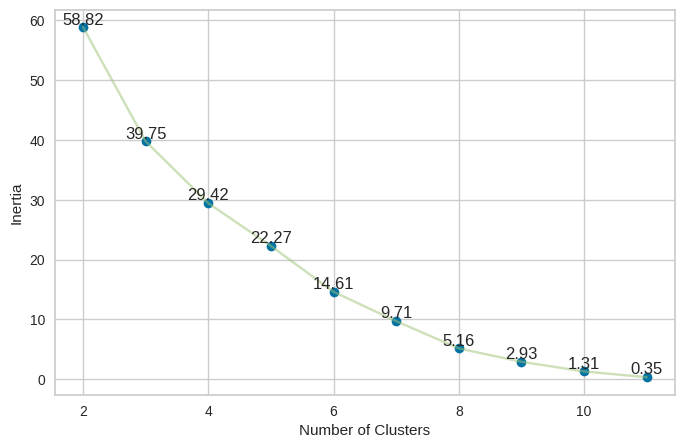

In [75]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)

    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

    for i, (x, y) in enumerate(zip(n_clusters, sum_of_squared_distance)):
        plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')

    return sum_of_squared_distance

# 군집화할 데이터 프레임인 df와 적절한 클러스터 개수를 지정하여 함수 호출
ssd = change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])


In [76]:
ssd # 클러스터 개수에 따른 응집도 결과 list

[58.82244124101932,
 39.752223612686905,
 29.423011501080843,
 22.267996968089975,
 14.614163375791584,
 9.713053072071627,
 5.155042461109344,
 2.9280637113052013,
 1.3121056110171179,
 0.34597680508110235]

In [77]:
# 클러스터 개수 4개로 지정
kmeans = KMeans(n_clusters=4, random_state = 2)
km_cluster = kmeans.fit_predict(df.iloc[:,1:])

df_clust = df.copy()
df_clust['km_cluster'] = km_cluster
df_clust['km_cluster'] = df_clust['km_cluster'].map({0:1, 1:3, 2:2, 3:0})

df_clust

,건물유형_라벨,day0,day1,day2,day3,day4,day5,day6,hour0,hour1,...,hour15,hour16,hour17,hour18,hour19,hour20,hour21,hour22,hour23,km_cluster
0,1,-1.233022,0.493279,0.428313,0.732009,1.049152,0.082529,-1.552261,-1.104439,-1.281583,...,1.319526,1.280776,0.979078,0.568049,0.570124,0.478785,0.108581,-0.557092,-0.671959,0
1,2,0.300225,0.891752,0.495555,0.680418,0.510658,-1.406645,-1.471964,-1.186759,-1.221977,...,1.031397,1.082928,0.938607,0.172981,-0.354670,-0.588760,-0.814909,-0.987800,-1.114858,1
2,3,0.458466,0.681282,0.541603,0.616991,0.617167,-1.559387,-1.356122,-0.826603,-0.941101,...,1.370965,1.071021,0.942307,0.465446,0.279741,0.052037,-0.195698,-0.492800,-0.607686,0
3,4,-0.053014,0.706756,-1.295208,-1.507448,0.747121,0.641651,0.760142,-0.702862,-0.871246,...,1.507725,1.598394,1.430010,0.799647,0.475830,0.121791,-0.344505,-0.279741,-0.504254,3
4,5,-2.250863,0.351745,0.234073,0.215852,0.413105,0.541644,0.494444,-1.034374,-1.036499,...,1.104460,1.078326,1.060161,1.020929,0.914533,0.306622,-0.718128,-0.971889,-1.019928,3
5,6,0.473407,0.792559,0.399882,0.611999,0.622410,-1.349763,-1.550494,-1.102422,-1.235610,...,1.167131,1.125828,0.676067,0.004905,-0.221135,-0.479973,-0.560324,-0.742677,-0.951707,1
6,7,-0.100396,0.755113,0.660694,0.740820,0.734664,-1.387936,-1.402960,-1.321732,-1.355785,...,1.001900,1.017186,0.981701,0.770083,0.459514,0.029591,-0.619797,-0.850932,-1.180267,1
7,8,0.478680,0.251015,-0.982379,-1.192531,-0.689667,0.535388,1.599493,-0.334857,-0.982607,...,0.101583,0.366842,0.756789,1.227963,1.600150,1.757692,1.558203,1.207232,0.488924,2
8,9,0.082628,0.815246,0.576001,0.811525,0.366336,-0.739289,-1.912445,-0.199844,-0.283374,...,1.801602,1.907998,1.134765,0.080610,-0.297840,-0.416835,-0.794002,-1.219000,-1.508787,0
9,10,0.176453,0.869926,0.432608,0.675978,0.696324,-1.330229,-1.521059,-1.055862,-1.112053,...,1.188362,1.128314,0.985514,0.461911,0.142647,-0.221499,-0.539009,-0.856169,-0.956629,1


In [78]:
df_clust.columns.tolist()

['건물유형_라벨',
 'day0',
 'day1',
 'day2',
 'day3',
 'day4',
 'day5',
 'day6',
 'hour0',
 'hour1',
 'hour2',
 'hour3',
 'hour4',
 'hour5',
 'hour6',
 'hour7',
 'hour8',
 'hour9',
 'hour10',
 'hour11',
 'hour12',
 'hour13',
 'hour14',
 'hour15',
 'hour16',
 'hour17',
 'hour18',
 'hour19',
 'hour20',
 'hour21',
 'hour22',
 'hour23',
 'km_cluster']

요일별 시간별 전력소비량 그래프 (왼:요일, 오:시간)

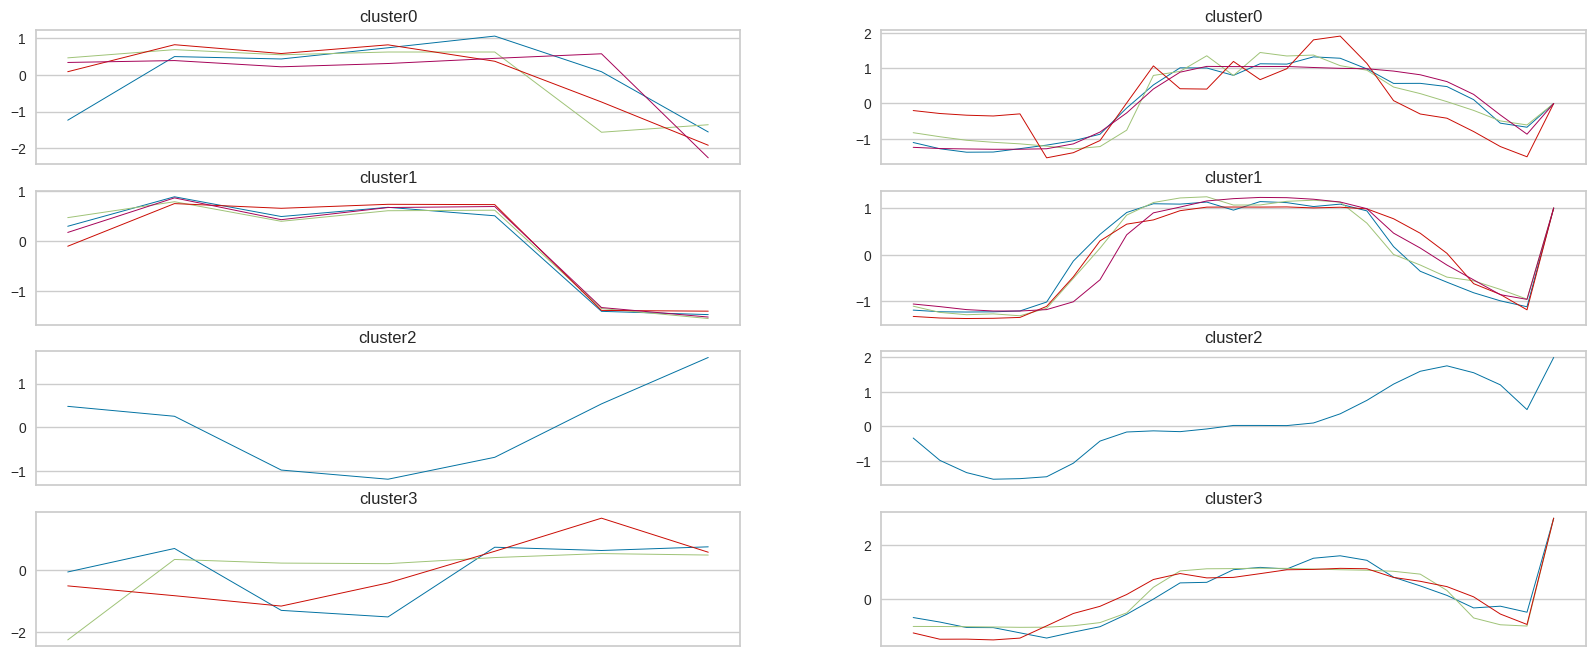

In [79]:
# visualizing result of kmeans clustering
n_c = len(np.unique(df_clust.km_cluster))

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = df_clust[df_clust.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)): # 요일별
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)): # 시간대별
        plt.plot(temp.iloc[i,8:], linewidth=0.7) # temp.iloc[i,8:-6]
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [80]:
combined_clust_df = combined_df.merge(df_clust[['건물유형_라벨','km_cluster']], on = '건물유형_라벨', how = 'left')
combined_clust_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,work_time,low_day,particular,km_cluster
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,1,False,0,0,0,0
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,1,False,0,0,0,0
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,1,False,0,0,0,0
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,1,False,0,0,0,0
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,1,False,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201835,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,1,12,False,1,0,0,3
201836,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,1,12,False,1,0,0,3
201837,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,1,12,False,1,0,0,3
201838,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,1,12,False,1,0,0,3


In [81]:
combined_clust_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,work_time,low_day,particular,km_cluster
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,0,1,False,0,0,0,0
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,0,1,False,0,0,0,0
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,0,1,False,0,0,0,0
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,0,1,False,0,0,0,0
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,0,1,False,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201835,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,0,1,12,False,1,0,0,3
201836,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,0,1,12,False,1,0,0,3
201837,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,0,1,12,False,1,0,0,3
201838,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,0,1,12,False,1,0,0,3


클러스터별 건물유형 출력

In [82]:
for cluster_num in range(4):
    buildings_in_cluster = combined_clust_df[combined_clust_df['km_cluster'] == cluster_num]['건물유형_라벨'].unique()
    print(f'Cluster {cluster_num}: {buildings_in_cluster}')

Cluster 0: [ 1  3  9 11]
Cluster 1: [ 2  6  7 10]
Cluster 2: [8]
Cluster 3: [ 4  5 12]


In [83]:
for cluster_num in range(4):
    buildings_in_cluster = combined_clust_df[combined_clust_df['km_cluster'] == cluster_num]['건물유형_라벨'].unique()
    arr = list()
    for df in buildings_in_cluster:
      btype = binfo_df[binfo_df['건물유형_라벨'] == df]['건물유형'].values[0]
      arr.append(btype)
    print(f'Cluster {cluster_num}: {arr}')

Cluster 0: ['건물기타', '대학교', '연구소', '할인마트']
Cluster 1: ['공공', '병원', '상용', '지식산업센터']
Cluster 2: ['아파트']
Cluster 3: ['데이터센터', '백화점및아울렛', '호텔및리조트']


클러스터별 전력소비량 그래프

In [84]:
# dictionary mapping cluster and building
match = df_clust[['건물유형_라벨','km_cluster']]
clust_to_num = {0:[],1:[],2:[],3:[]}
for i in range(12):
    c = match.iloc[i,1]
    clust_to_num[c].append(i+1)

In [85]:
clust_to_num

{0: [1, 3, 9, 11], 1: [2, 6, 7, 10], 2: [8], 3: [4, 5, 12]}

In [86]:
combined_clust_df['datetime'] = pd.to_datetime('2022-' + combined_clust_df['월'].astype(str) + '-' + combined_clust_df['일'].astype(str))
combined_clust_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,...,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,work_time,low_day,particular,km_cluster,datetime
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,63.09388,63.093880,63.093880,True,...,0,0,0,1,False,0,0,0,0,2022-06-01
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,62.46400,62.778940,62.778940,True,...,0,0,0,1,False,0,0,0,0,2022-06-01
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,62.08735,62.548410,62.548410,True,...,0,0,0,1,False,0,0,0,0,2022-06-01
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,60.89884,61.816730,62.136017,True,...,0,0,0,1,False,0,0,0,0,2022-06-01
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,62.88788,61.958023,62.286390,True,...,0,0,0,1,False,0,0,0,0,2022-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201835,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,72.38034,74.061867,74.322108,False,...,0,0,1,12,False,1,0,0,3,2022-08-24
201836,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,71.21736,72.678320,73.678128,False,...,0,0,1,12,False,1,0,0,3,2022-08-24
201837,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,69.79704,71.131580,72.640000,False,...,0,0,1,12,False,1,0,0,3,2022-08-24
201838,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,69.41060,70.141667,71.448520,False,...,0,0,1,12,False,1,0,0,3,2022-08-24


In [87]:
combined_clust_df.describe()

,건물번호,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,월,일,...,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,work_time,low_day,particular,km_cluster
count,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,...,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000
mean,50.687277,25.567179,2.129615,78.776936,2400.864164,75.462416,75.458423,75.453864,6.939358,14.828181,...,0.080856,0.080856,0.080856,0.080856,0.080856,6.213436,0.550411,0.131272,0.005821,1.089774
std,28.962936,3.774340,1.358261,15.048475,2387.172083,5.448061,5.409489,5.354180,0.792286,8.443628,...,0.272615,0.272615,0.272615,0.272615,0.272615,3.655700,0.497453,0.337699,0.076076,1.128344
min,1.000000,10.100000,0.000000,13.000000,0.000000,50.481070,51.276703,51.735894,6.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,23.400000,1.200000,69.000000,1080.360000,72.617760,72.660833,72.679919,6.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,51.000000,25.700000,2.000000,81.000000,1748.520000,76.312960,76.319913,76.342258,7.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000,1.000000
75%,76.000000,28.100000,2.800000,91.000000,2928.480000,79.401640,79.365643,79.331946,8.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,2.000000
max,100.000000,37.100000,13.300000,100.000000,25488.400000,87.789790,87.330393,87.210598,8.000000,31.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,1.000000,1.000000,3.000000


## 테스트용 et

In [133]:
combined_clust_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/combined_clust_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/test_df.csv')

In [134]:
combined_clust_df['요일_sin'] = -np.sin(2 * np.pi * (combined_clust_df['요일']+1)/7.0)
combined_clust_df['요일_cos'] = -np.cos(2 * np.pi * (combined_clust_df['요일']+1)/7.0)

In [135]:
combined_clust_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'km_cluster',
 'datetime',
 'work_time',
 'low_day',
 'particular',
 '요일_sin',
 '요일_cos']

In [109]:
combined_clust_df.describe()

,건물번호,기온(C),풍속(m/s),습도(%),전력소비량(kWh),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,월,일,...,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,km_cluster,work_time,low_day,particular,요일_sin,요일_cos
count,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,...,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,201840.000000,2.018400e+05,201840.000000
mean,50.687277,25.567179,2.129615,78.776936,2400.864164,75.462416,75.458423,75.453864,6.939358,14.828181,...,0.080856,0.080856,0.080856,6.213436,1.373365,0.550411,0.131272,0.005821,-5.159141e-03,0.010070
std,28.962936,3.774340,1.358261,15.048475,2387.172083,5.448061,5.409489,5.354180,0.792286,8.443628,...,0.272615,0.272615,0.272615,3.655700,1.291963,0.497453,0.337699,0.076076,7.046215e-01,0.709497
min,1.000000,10.100000,0.000000,13.000000,0.000000,50.481070,51.276703,51.735894,6.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-9.749279e-01,-1.000000
25%,25.000000,23.400000,1.200000,69.000000,1080.360000,72.617760,72.660833,72.679919,6.000000,8.000000,...,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-7.818315e-01,-0.623490
50%,51.000000,25.700000,2.000000,81.000000,1748.520000,76.312960,76.319913,76.342258,7.000000,15.000000,...,0.000000,0.000000,0.000000,6.000000,1.000000,1.000000,0.000000,0.000000,2.449294e-16,0.222521
75%,76.000000,28.100000,2.800000,91.000000,2928.480000,79.401640,79.365643,79.331946,8.000000,22.000000,...,0.000000,0.000000,0.000000,9.000000,3.000000,1.000000,0.000000,0.000000,7.818315e-01,0.900969
max,100.000000,37.100000,13.300000,100.000000,25488.400000,87.789790,87.330393,87.210598,8.000000,31.000000,...,1.000000,1.000000,1.000000,12.000000,3.000000,1.000000,1.000000,1.000000,9.749279e-01,0.900969


Cluster 0: ['건물기타', '대학교', '연구소', '할인마트']  
Cluster 1: ['백화점및아울렛', '호텔및리조트']  
Cluster 2: ['데이터센터', '아파트']  
Cluster 3: ['공공', '병원', '상용', '지식산업센터']

In [110]:
clust_to_num = {0: [1, 3, 9, 11], 1: [5, 12], 2: [4, 8], 3: [2, 6, 7, 10]}

In [111]:
model_type = 'et'

In [152]:
selected_columns = [
    '전력소비량(kWh)',
    '건물번호',
    '기온(C)',
    '풍속(m/s)',
    '습도(%)',
    '불쾌지수',
    '불쾌지수_이동평균3',
    'holiday',
    '월',
    '일',
    '시간',
    '시간_sin',
    '시간_cos',
    '요일',
    '연면적(m2)',
    '냉방면적(m2)',
    '태양광용량(kW)',
    'ESS저장용량(kWh)',
    '건물기타',
    '공공',
    '대학교',
    '데이터센터',
    '백화점및아울렛',
    '병원',
    '상용',
    '아파트',
    '연구소',
    '지식산업센터',
    '할인마트',
    '호텔및리조트',
    '건물유형_라벨',
    'work_time',
    'low_day',
    'particular',
    '요일_sin',
    '요일_cos',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]


clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)
clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)
clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)
clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



#### clust0

In [137]:
selected_columns0 = ['전력소비량(kWh)',
 '연면적(m2)',
 '건물번호',
 '시간_cos',
 '연구소',
 'holiday',
 '냉방면적(m2)',
 'ESS저장용량(kWh)',
 '불쾌지수',
 '대학교',
 '시간',
 '시간_sin',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 '월',
 '불쾌지수_이동평균5',
 '기온(C)',
 '요일',
 '일',
 '습도(%)',
 '풍속(m/s)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns0]

clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)



In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust0_train_df, clust0_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

xgboost test용

In [155]:
selected_columns = [
    '전력소비량(kWh)',
    '연면적(m2)',
    'work_time',
    '건물번호',
    'holiday',
    'particular',
    '냉방면적(m2)',
    '불쾌지수',
    'low_day',
    '시간',
    '시간_sin',
    '시간_cos',
    '불쾌지수_이동평균3',
    '태양광용량(kW)',
    'ESS저장용량(kWh)',
    '월',
    '기온(C)',
    '요일',
    '요일_sin',
    '요일_cos',
    '일',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]


clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)

In [156]:
# Feature와 Target을 분리합니다.
X = clust0_train_df.drop(columns=['전력소비량(kWh)', 'km_cluster'])
y = clust0_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 모델의 예측값을 생성합니다.
y_pred = xgb_model.predict(X_test)

# SMAPE를 계산하여 모델의 성능을 평가합니다.
smape_score = smape_fnc(y_test, y_pred)
print(f"SMAPE: {smape_score:.5f}")

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

SMAPE: 8.30138


,Feature,Importance
0,연면적(m2),0.638628
1,work_time,0.091992
3,holiday,0.054474
5,냉방면적(m2),0.046615
2,건물번호,0.044009
4,particular,0.043630
10,시간_cos,0.022424
12,태양광용량(kW),0.012177
6,불쾌지수,0.010294
8,시간,0.007116


In [144]:
importance_df.Feature.tolist()

['연면적(m2)',
 'work_time',
 'holiday',
 '냉방면적(m2)',
 'particular',
 '건물번호',
 '시간_cos',
 '태양광용량(kW)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '시간',
 'low_day',
 'ESS저장용량(kWh)',
 '월',
 '시간_sin',
 '기온(C)',
 '요일_sin',
 '요일',
 '일',
 '요일_cos']

In [ ]:
# Feature와 Target을 분리합니다.
X = clust0_train_df.drop(columns=['전력소비량(kWh)'])
y = clust0_train_df['전력소비량(kWh)']

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X, y)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

In [ ]:
importance_df.Feature.tolist()

변수 3개 추가 / 제출용

In [ ]:
selected_columns = [
    '전력소비량(kWh)',
    '연면적(m2)',
    'work_time',
    '건물번호',
    'holiday',
    'particular',
    '냉방면적(m2)',
    '불쾌지수',
    'low_day',
    '시간',
    '시간_sin',
    '시간_cos',
    '불쾌지수_이동평균3',
    '태양광용량(kW)',
    'ESS저장용량(kWh)',
    '월',
    '기온(C)',
    '요일',
    '요일_sin',
    '요일_cos',
    '일',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]


clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)

In [ ]:

# pycaret 설정
exp0 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'0')




#### clust1

In [ ]:
selected_columns1 = ['전력소비량(kWh)',
 '시간_cos',
 '냉방면적(m2)',
 '시간',
 '연면적(m2)',
 '시간_sin',
 '건물번호',
 '불쾌지수_이동평균3',
 '월',
 '불쾌지수',
 'holiday',
 '요일',
 '불쾌지수_이동평균5',
 '태양광용량(kW)',
 '일',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns1]

clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)



In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust1_train_df, clust1_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

xgboost test용

In [196]:
selected_columns = [
    '전력소비량(kWh)',
    'work_time',
    '연면적(m2)',
    '냉방면적(m2)',
    '시간',
    '시간_sin',
    '시간_cos',
    '건물번호',
    '불쾌지수',
    '월',
    '기온(C)',
    '요일',
    'holiday',
    '불쾌지수_이동평균3',
    '태양광용량(kW)',
    '일',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]


clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)


In [201]:
# Feature와 Target을 분리합니다.
X = clust1_train_df.drop(columns=['전력소비량(kWh)','km_cluster'])
y = clust1_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 모델의 예측값을 생성합니다.
y_pred = xgb_model.predict(X_test)

# SMAPE를 계산하여 모델의 성능을 평가합니다.
smape_score = smape_fnc(y_test, y_pred)
print(f"SMAPE: {smape_score:.5f}")

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

SMAPE: 7.18729


,Feature,Importance
0,work_time,0.650152
1,연면적(m2),0.156416
2,냉방면적(m2),0.047291
3,시간,0.037941
4,건물번호,0.030705
5,시간_cos,0.027225
6,불쾌지수,0.010208
8,기온(C),0.010084
7,월,0.007262
10,시간_sin,0.005613


In [148]:
importance_df.Feature.tolist()

['work_time',
 '연면적(m2)',
 '냉방면적(m2)',
 '시간',
 '시간_cos',
 '건물번호',
 '불쾌지수',
 '월',
 '기온(C)',
 '요일',
 '시간_sin',
 'holiday',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 '일',
 '습도(%)',
 '요일_cos',
 '풍속(m/s)',
 '요일_sin',
 'ESS저장용량(kWh)',
 '공공',
 'particular',
 'low_day',
 '건물유형_라벨',
 '호텔및리조트',
 '할인마트',
 '지식산업센터',
 '연구소',
 '아파트',
 '상용',
 '병원',
 '백화점및아울렛',
 '데이터센터',
 '대학교',
 '건물기타']

In [99]:
# Feature와 Target을 분리합니다.
X = clust1_train_df.drop(columns=['전력소비량(kWh)'])
y = clust1_train_df['전력소비량(kWh)']

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X, y)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

,Feature,Importance
31,work_time,0.630787
14,연면적(m2),0.194994
15,냉방면적(m2),0.036449
10,시간,0.034804
12,시간_cos,0.033040
0,건물번호,0.019032
4,불쾌지수,0.012528
5,불쾌지수_이동평균3,0.006226
8,월,0.006073
11,시간_sin,0.005288


In [ ]:
importance_df.Feature.tolist()

변수 3개 추가 / 제출용

In [ ]:
selected_columns = [
    '전력소비량(kWh)',
    'work_time',
    '연면적(m2)',
    '냉방면적(m2)',
    '시간',
    '시간_sin',
    '시간_cos',
    '건물번호',
    '불쾌지수',
    '월',
    '기온(C)',
    '요일',
    'holiday',
    '불쾌지수_이동평균3',
    '태양광용량(kW)',
    '일',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]


clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)


In [ ]:
# pycaret 설정
exp0 = setup(data=clust1_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'1')

####clust2

In [ ]:
selected_columns2 = ['전력소비량(kWh)',
 '건물번호',
 '냉방면적(m2)',
 '불쾌지수_이동평균5',
 '연면적(m2)',
 '시간',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 'holiday',
 '시간_cos',
 '일',
 '습도(%)',
 '요일',
 '기온(C)',
 '풍속(m/s)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust2_train_df, clust2_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

xgboost test용

In [175]:
# selected_columns = [
#     '전력소비량(kWh)',
#     '건물번호',
#     '냉방면적(m2)',
#     'work_time',
#     '불쾌지수_이동평균3',
#     '시간',
#     '시간_sin',
#     '시간_cos',
#     '연면적(m2)',
#     '월',
#     '불쾌지수',
#     'holiday',
#     '요일',
#     '요일_sin',
#     '요일_cos',
#     '일',
#     '기온(C)',
#     'km_cluster'
# ]

# combined_clust_train_df = combined_clust_df[selected_columns]


# clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [212]:
selected_columns2 = ['전력소비량(kWh)',
 '건물번호',
 '냉방면적(m2)',
 '연면적(m2)',
 '시간',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 'holiday',
 '시간_cos',
 '일',
 '요일',
 '기온(C)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [213]:
# Feature와 Target을 분리합니다.
X = clust2_train_df.drop(columns=['전력소비량(kWh)'])
y = clust2_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 모델의 예측값을 생성합니다.
y_pred = xgb_model.predict(X_test)

# SMAPE를 계산하여 모델의 성능을 평가합니다.
smape_score = smape_fnc(y_test, y_pred)
print(f"SMAPE: {smape_score:.5f}")

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

SMAPE: 3.62514


,Feature,Importance
0,건물번호,0.939312
1,냉방면적(m2),0.034746
3,시간,0.008429
7,불쾌지수_이동평균3,0.007136
5,월,0.003462
4,불쾌지수,0.001731
6,시간_sin,0.001584
2,연면적(m2),0.001304
8,holiday,0.000565
9,시간_cos,0.000562


In [174]:
importance_df.Feature.tolist()

['건물번호',
 '냉방면적(m2)',
 'work_time',
 '불쾌지수_이동평균3',
 '시간',
 '연면적(m2)',
 '월',
 '불쾌지수',
 '시간_sin',
 'holiday',
 '시간_cos',
 '요일',
 '일',
 '습도(%)',
 '요일_sin',
 '요일_cos',
 '기온(C)',
 '풍속(m/s)',
 '연구소',
 'particular',
 'low_day',
 '건물유형_라벨',
 '호텔및리조트',
 '할인마트',
 '지식산업센터',
 '공공',
 '아파트',
 '상용',
 '병원',
 '백화점및아울렛',
 '데이터센터',
 '대학교',
 '건물기타',
 'ESS저장용량(kWh)',
 '태양광용량(kW)',
 'km_cluster']

In [ ]:
# Feature와 Target을 분리합니다.
X = clust0_train_df.drop(columns=['전력소비량(kWh)'])
y = clust0_train_df['전력소비량(kWh)']

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X, y)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

In [ ]:
importance_df.Feature.tolist()

변수 3개 추가 / 제출용

In [ ]:
selected_columns2 = ['전력소비량(kWh)',
 '건물번호',
 '냉방면적(m2)',
 '연면적(m2)',
 '시간',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 'holiday',
 '시간_cos',
 '일',
 '요일',
 '기온(C)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [ ]:
# pycaret 설정
exp0 = setup(data=clust2_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'2')

#### clust3

In [ ]:
selected_columns3 = ['전력소비량(kWh)',
 '병원',
 '시간_cos',
 '연면적(m2)',
 'holiday',
 '냉방면적(m2)',
 '건물번호',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '불쾌지수',
 '시간_sin',
 '상용',
 '월',
 '불쾌지수_이동평균3',
 '시간',
 '불쾌지수_이동평균5',
 '요일',
 '기온(C)',
 '일',
 '습도(%)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns3]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



xgboost test용

In [192]:
selected_columns = [
    '전력소비량(kWh)',
    '병원',
    'work_time',
    'low_day',
    '연면적(m2)',
    '냉방면적(m2)',
    'holiday',
    'ESS저장용량(kWh)',
    '건물번호',
    '태양광용량(kW)',
    '불쾌지수',
    '월',
    '불쾌지수_이동평균3',
    '상용',
    '시간',
    '시간_sin',
    '시간_cos',
    '기온(C)',
    '일',
    '요일',
    '요일_sin',
    '요일_cos',
    'particular',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)


In [193]:
# Feature와 Target을 분리합니다.
X = clust3_train_df.drop(columns=['전력소비량(kWh)'])
y = clust3_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 모델의 예측값을 생성합니다.
y_pred = xgb_model.predict(X_test)

# SMAPE를 계산하여 모델의 성능을 평가합니다.
smape_score = smape_fnc(y_test, y_pred)
print(f"SMAPE: {smape_score:.5f}")

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

SMAPE: 5.68970


,Feature,Importance
0,병원,0.265961
1,work_time,0.211402
3,연면적(m2),0.092260
2,low_day,0.089714
4,냉방면적(m2),0.073734
5,holiday,0.057406
15,시간_cos,0.054395
6,ESS저장용량(kWh),0.037239
7,건물번호,0.036774
8,태양광용량(kW),0.020601


In [187]:
importance_df.Feature.tolist()

['병원',
 'work_time',
 'low_day',
 '연면적(m2)',
 '냉방면적(m2)',
 'holiday',
 '시간_cos',
 'ESS저장용량(kWh)',
 '건물번호',
 '태양광용량(kW)',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 '상용',
 '시간',
 '기온(C)',
 '일',
 '요일',
 '요일_sin',
 '습도(%)',
 'particular',
 '풍속(m/s)',
 '요일_cos',
 '할인마트',
 '건물유형_라벨',
 '호텔및리조트',
 '공공',
 '지식산업센터',
 '연구소',
 '아파트',
 '백화점및아울렛',
 '데이터센터',
 '대학교',
 '건물기타',
 'km_cluster']

In [ ]:
# Feature와 Target을 분리합니다.
X = clust0_train_df.drop(columns=['전력소비량(kWh)'])
y = clust0_train_df['전력소비량(kWh)']

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X, y)

# 변수 중요도 계산
feature_importances = xgb_model.feature_importances_

# 변수명과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)

importance_df

In [ ]:
importance_df.Feature.tolist()

변수 3개 추가 / 제출용

In [ ]:
selected_columns = [
    '전력소비량(kWh)',
    '병원',
    'work_time',
    'low_day',
    '연면적(m2)',
    '냉방면적(m2)',
    'holiday',
    'ESS저장용량(kWh)',
    '건물번호',
    '태양광용량(kW)',
    '불쾌지수',
    '월',
    '불쾌지수_이동평균3',
    '상용',
    '시간',
    '시간_sin',
    '시간_cos',
    '기온(C)',
    '일',
    '요일',
    '요일_sin',
    '요일_cos',
    'particular',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)


In [ ]:
# pycaret 설정
exp0 = setup(data=clust3_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 기본 모델 생성
et_model0 = create_model(model_type)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'3')

## 각 군집별로 모델 생성(et) +모델별 feature 추가

In [ ]:
combined_clust_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '건물유형',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'work_time',
 'low_day',
 'particular',
 'km_cluster',
 'datetime']

Cluster 0: ['건물기타', '대학교', '연구소', '할인마트']  
Cluster 1: ['백화점및아울렛', '호텔및리조트']  
Cluster 2: ['데이터센터', '아파트']  
Cluster 3: ['공공', '병원', '상용', '지식산업센터']

In [ ]:
clust_to_num

{0: [1, 3, 9, 11], 1: [5, 12], 2: [4, 8], 3: [2, 6, 7, 10]}

In [ ]:
model_type = 'et'

In [ ]:
selected_columns = [
    '건물번호',
    '기온(C)',
    '풍속(m/s)',
    '습도(%)',
    '전력소비량(kWh)',
    '불쾌지수',
    '불쾌지수_이동평균3',
    '불쾌지수_이동평균5',
    'holiday',
    '월',
    '일',
    '시간',
    '시간_sin',
    '시간_cos',
    '요일',
    '연면적(m2)',
    '냉방면적(m2)',
    '태양광용량(kW)',
    'ESS저장용량(kWh)',
    '건물기타',
    '공공',
    '대학교',
    '데이터센터',
    '백화점및아울렛',
    '병원',
    '상용',
    '아파트',
    '연구소',
    '지식산업센터',
    '할인마트',
    '호텔및리조트',
    '건물유형_라벨',
    'km_cluster'
]

combined_clust_train_df = combined_clust_df[selected_columns]

# column_name_mapping = {
#     '건물번호': 'Building Number',
#     '기온(C)': 'Temperature (C)',
#     '풍속(m/s)': 'Wind Speed (m/s)',
#     '습도(%)': 'Humidity (%)',
#     '불쾌지수': 'Discomfort Index',
#     '불쾌지수_이동평균3': 'Moving Average Discomfort Index (3)',
#     '불쾌지수_이동평균5': 'Moving Average Discomfort Index (5)',
#     'holiday': 'Holiday',
#     '월': 'Month',
#     '일': 'Day',
#     '시간': 'Hour',
#     '시간_sin': 'Hour_sin',
#     '시간_cos': 'Hour_cos',
#     '요일': 'Day of Week',
#     '건물유형': 'Building Type',
#     '연면적(m2)': 'Total Floor Area (m2)',
#     '냉방면적(m2)': 'Cooling Area (m2)',
#     '태양광용량(kW)': 'Solar Capacity (kW)',
#     'ESS저장용량(kWh)': 'ESS Storage Capacity (kWh)',
#     '건물기타': 'Building Type (Other)',
#     '공공': 'Public',
#     '대학교': 'University',
#     '데이터센터': 'Data Center',
#     '백화점및아울렛': 'Department Store/Outlet',
#     '병원': 'Hospital',
#     '상용': 'Commercial',
#     '아파트': 'Apartment',
#     '연구소': 'Research Institute',
#     '지식산업센터': 'Knowledge Industry Center',
#     '할인마트': 'Discount Mart',
#     '호텔및리조트': 'Hotel/Resort',
#     '건물유형_라벨': 'Building Type Label',
# }

# # 데이터프레임의 컬럼 이름을 영어로 변경
# combined_clust_train_df.rename(columns=column_name_mapping, inplace=True)


clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)
clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)
clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)
clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)

combined_clust_train_df.columns.tolist()


#### clust0

In [ ]:
selected_columns0 = ['전력소비량(kWh)',
 '연면적(m2)',
 '건물번호',
 '시간_cos',
 '연구소',
 'holiday',
 '냉방면적(m2)',
 'ESS저장용량(kWh)',
 '불쾌지수',
 '대학교',
 '시간',
 '시간_sin',
 '불쾌지수_이동평균3',
 '태양광용량(kW)',
 '월',
 '불쾌지수_이동평균5',
 '기온(C)',
 '요일',
 '일',
 '습도(%)',
 '풍속(m/s)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns0]

clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)



In [ ]:
selected_columns0 = ['전력소비량(kWh)',
 '연면적(m2)', '연구소', 'work_time', '건물번호', 'holiday', 'particular', '냉방면적(m2)', '시간_cos', '대학교', '불쾌지수', 'low_day', '불쾌지수_이동평균3', '시간', '태양광용량(kW)', 'ESS저장용량(kWh)', '월', '불쾌지수_이동평균5', '시간_sin', '기온(C)', '요일', '일',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns0]

clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)



In [ ]:

# pycaret 설정
exp0 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

exp0.add_metric('smape', 'SMAPE', custom_metrics, greater_is_better = False)


# 모델 학습 및 비교
best_model = compare_models(sort = 'smape')
print(best_model)

# 기본 모델 생성
et_model0 = create_model(best_model)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model0 = tune_model(et_model0)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+model_type+'0')




In [ ]:

# pycaret 설정
exp0 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 모델 학습 및 비교
# best_model = compare_models()
# print(best_model)

# 기본 모델 생성
et_model0 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model0 = tune_model(et_model0)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+'et_model_final_'+model_type+'0')




In [ ]:
# 변수 상위 13개


# selected_columns0 = ['건물번호',
#     '기온(C)',
#     '전력소비량(kWh)',
#     '불쾌지수',
#     '불쾌지수_이동평균3',
#     '불쾌지수_이동평균5',
#     'holiday',
#     '월',
#     '일',
#     '시간',
#     '시간_sin',
#     '시간_cos',
#     '요일',
#     '연면적(m2)',
#     '냉방면적(m2)',
#     '태양광용량(kW)',
#     'ESS저장용량(kWh)',
#     '건물기타',
#     '대학교',
#     '연구소',
#     'km_cluster']
# combined_clust_train_df = combined_clust_df[selected_columns0]

# clust0_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 0].reset_index(drop=True)



In [ ]:
# 스태킹

# from pycaret.regression import *

# # pycaret 설정
# exp0 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# # 기본 모델 생성
# et_model = create_model('et')  # 선형 회귀 모델
# rf_model = create_model('rf')  # 랜덤 포레스트 모델
# lightgbm_model = create_model('lightgbm')  # LightGBM 모델

# # 모델 리스트
# models = [et_model, rf_model, lightgbm_model]

# stacker = stack_models(estimator_list = models, meta_model = et_model)


In [ ]:
# # StandardScaler 객체 생성 및 학습


# # scaler = StandardScaler()
# # scaled_data = scaler.fit_transform(clust0_train_df)
# # clust0_train_df = pd.DataFrame(scaled_data, columns=clust0_train_df.columns)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(clust0_train_df)
# clust0_train_df = pd.DataFrame(scaled_data, columns=clust0_train_df.columns)

 rfecv

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesRegressor

# Feature와 Target을 분리합니다.
X = clust0_train_df.drop(columns=['전력소비량(kWh)','km_cluster'])
y = clust0_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extra Tree 회귀 모델을 생성하고 학습합니다.
extra_tree_model = ExtraTreesRegressor(random_state=42)
extra_tree_model.fit(X_train, y_train)

# RFECV로 특성 선택
rfecv = RFECV(estimator=extra_tree_model, step=1, cv=5)
rfecv.fit(X_train, y_train)

# 선택된 특성 인덱스 추출
selected_features_idx = rfecv.support_

# 선택된 특성으로 데이터를 필터링합니다.
X_train_selected = X_train.iloc[:, selected_features_idx]
X_test_selected = X_test.iloc[:, selected_features_idx]




In [ ]:
X_train_selected.columns.tolist()

['건물번호',
 '기온(C)',
 '습도(%)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '대학교',
 '연구소',
 '할인마트',
 '건물유형_라벨']

In [ ]:
columns0 = X_train_selected.columns.tolist()
columns0.append('전력소비량(kWh)')
clust0_train_df = combined_clust_train_df[columns0]

# pycaret 설정
exp0 = setup(data=clust0_train_df, target='전력소비량(kWh)')

# 모델 학습 및 비교
# best_model = compare_models()
# print(best_model)

# 기본 모델 생성
et_model0 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model0 = tune_model(et_model0)

# 최종 모델 생성
final_et_model0 = finalize_model(et_model0)

# 모델 저장
save_model(final_et_model0, path+'rfecv_'+model_type+'0')




,Description,Value
0,Session id,8694
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 23)"
4,Transformed data shape,"(204000, 23)"
5,Transformed train set shape,"(142800, 23)"
6,Transformed test set shape,"(61200, 23)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,69.5741,17196.5534,131.1356,0.9971,0.0716,0.0389
1,68.9404,16092.4986,126.8562,0.9974,0.0708,0.0383
2,70.2634,17169.1770,131.0312,0.9971,0.0697,0.0385
3,69.8053,16303.4024,127.6848,0.9973,0.0715,0.0392
4,71.4924,17596.1341,132.6504,0.9969,0.0963,0.2829
5,69.2376,16458.3049,128.2899,0.9972,0.0722,0.0389
6,68.9289,15746.1834,125.4838,0.9974,0.0725,0.0391
7,70.3202,17551.8979,132.4836,0.9972,0.0759,0.0399
8,71.2984,17760.0081,133.2667,0.9969,0.0751,0.0405


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['건물번호', '기온(C)', '습도(%)', '불쾌지수',
                                              '불쾌지수_이동평균3', '불쾌지수_이동평균5', '월',
                                              '일', '시간', '시간_sin', '시간_cos',
                                              '요일', '연면적(m2)', '냉방면적(m2)',
                                              '태양광용량(kW)', 'ESS저장용량(kWh)',
                                              '건물기타', '대학교', '연구소', '할인마트',
                                              '건물유형_라벨'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_est

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

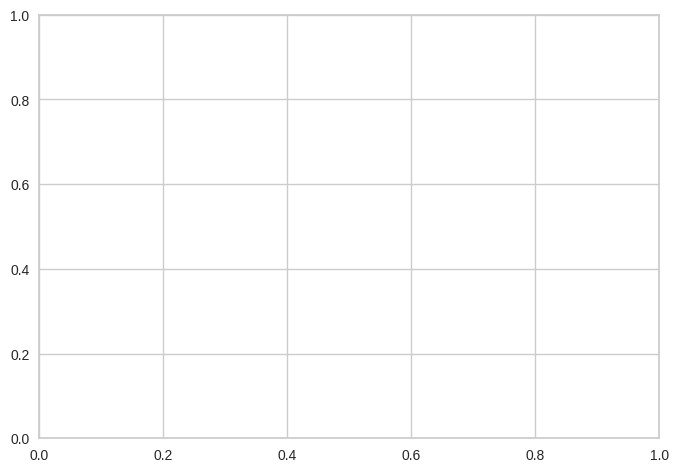

In [ ]:
# evaluate_model(final_et_model0)

In [ ]:
# # 모델에서 변수 중요도 얻기
# feature_importances = final_et_model0.feature_importances_
# np.sort(feature_importances)[::-1]

array([0.37644166, 0.24822544, 0.08989987, 0.05501021, 0.04829344,
       0.04755323, 0.03796084, 0.02363355, 0.01452751, 0.00752492,
       0.00751808, 0.00694515, 0.00483131, 0.00480167, 0.00413029,
       0.00373269, 0.00310224, 0.00309776, 0.00255906, 0.00207402,
       0.00199296, 0.00184546, 0.00154257, 0.00084868, 0.000653  ,
       0.00063042, 0.00062394, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

test 데이터 검증

In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust0_train_df, clust0_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model0 = create_model(model_type)
final_et_model0 = finalize_model(et_model0)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model0, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

# 모델 저장
save_model(final_et_model0, path+'et_model_final_'+model_type+'0')


,Description,Value
0,Session id,6279
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(63648, 22)"
4,Transformed data shape,"(63648, 22)"
5,Transformed train set shape,"(44553, 22)"
6,Transformed test set shape,"(19095, 22)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,92.5360,26048.8530,161.3966,0.9973,0.0862,0.0474
1,86.2897,22844.5394,151.1441,0.9976,0.0847,0.0460
2,91.3509,25304.9063,159.0752,0.9977,0.0823,0.0460
3,89.5039,24635.1848,156.9560,0.9977,0.0796,0.0451
4,93.5794,31561.3750,177.6552,0.9970,0.0921,0.0494
5,93.0191,25888.6570,160.8995,0.9974,0.0872,0.0479
6,92.4640,26635.1652,163.2028,0.9974,0.0871,0.0481
7,93.1154,27470.6602,165.7428,0.9972,0.0885,0.0475
8,88.8137,27257.6742,165.0990,0.9973,0.0839,0.0460


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,79.1803,20256.4661,142.3252,0.9979,0.0737,0.0401


SMAPE: 3.88428
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['연면적(m2)', '연구소', 'work_time',
                                              '건물번호', 'particular', '냉방면적(m2)',
                                              '시간_cos', '대학교', '불쾌지수', 'low_day',
                                              '불쾌지수_이동평균3', '시간', '태양광용량(kW)',
                                              'ESS저장용량(kWh)', '월', '불쾌지수_이동평균5',
                                              '시간_sin', '기온(C)', '요일', '일'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegress

#### clust1

In [ ]:
selected_columns1 = ['전력소비량(kWh)',
 '시간_cos',
 '냉방면적(m2)',
 '시간',
 '연면적(m2)',
 '시간_sin',
 '건물번호',
 '불쾌지수_이동평균3',
 '월',
 '불쾌지수',
 'holiday',
 '요일',
 '불쾌지수_이동평균5',
 '태양광용량(kW)',
 '일',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns1]

clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)



In [ ]:
selected_columns1 = ['전력소비량(kWh)',
'work_time', '연면적(m2)', '냉방면적(m2)', '시간', '건물번호', '시간_cos', '불쾌지수', '월', '기온(C)', 'holiday', '시간_sin', '불쾌지수_이동평균3', '요일', '불쾌지수_이동평균5', '일', '습도(%)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns1]

clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)



In [ ]:

# pycaret 설정
exp1 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

exp1.add_metric('smape', 'SMAPE', custom_metrics, greater_is_better = False)


# 모델 학습 및 비교
best_model = compare_models(sort = 'smape')
print(best_model)

# 기본 모델 생성
et_model1 = create_model(best_model)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model0 = tune_model(et_model1)

# 최종 모델 생성
final_et_model1 = finalize_model(et_model1)

# 모델 저장
save_model(final_et_model1, path+model_type+'1')




,Description,Value
0,Session id,6895
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(79560, 24)"
4,Transformed data shape,"(79560, 24)"
5,Transformed train set shape,"(55692, 24)"
6,Transformed test set shape,"(23868, 24)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,87.6546,24003.7874,154.8485,0.9976,0.0822,0.0453,4.3372,16.7320
rf,Random Forest Regressor,97.0071,29156.9008,170.7022,0.9971,0.0810,0.0475,4.5782,32.4710
dt,Decision Tree Regressor,124.8013,55000.9584,234.4181,0.9946,0.1064,0.0592,5.7786,0.7220
xgboost,Extreme Gradient Boosting,140.4310,46779.7324,216.2488,0.9954,0.1177,0.0771,7.4194,6.0170
lightgbm,Light Gradient Boosting Machine,170.0894,62673.0639,250.2995,0.9938,0.1362,0.0952,8.8880,3.2430
gbr,Gradient Boosting Regressor,353.1174,273055.1675,522.3602,0.9730,0.2375,0.1904,16.8903,8.7580
knn,K Neighbors Regressor,736.5907,2848997.0750,1687.3511,0.7181,0.3783,0.3110,22.5650,1.2640
ada,AdaBoost Regressor,1070.9034,1676170.6936,1294.5637,0.8339,0.6380,0.7734,46.9269,3.5980
huber,Huber Regressor,1430.6844,8082497.0927,2842.2403,0.2003,0.6947,0.5856,49.2771,0.7520
en,Elastic Net,1547.1038,6697212.2500,2587.5398,0.3370,0.7790,0.8124,55.5285,0.2130


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=6895)


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,88.1452,27623.6514,166.2036,0.9973,0.0859,0.0462,4.3807
1,88.8593,24138.5816,155.3660,0.9974,0.0857,0.0469,4.4668
2,86.7520,23618.3909,153.6828,0.9977,0.0747,0.0425,4.1364
3,84.4488,22638.5305,150.4611,0.9976,0.0819,0.0441,4.2276
4,87.6097,23921.3888,154.6654,0.9976,0.0887,0.0475,4.4707
5,87.1909,21965.6504,148.2081,0.9979,0.0776,0.0436,4.2406
6,88.8189,25427.8517,159.4611,0.9976,0.0895,0.0474,4.4261
7,90.2797,24852.8407,157.6478,0.9976,0.0789,0.0454,4.3976
8,86.1720,22238.5035,149.1258,0.9979,0.0774,0.0436,4.2279


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['연면적(m2)', '건물번호', '시간_cos', '연구소',
                                              '냉방면적(m2)', 'ESS저장용량(kWh)', '불쾌지수',
                                              '대학교', '시간', '시간_sin',
                                              '불쾌지수_이동평균3', '태양광용량(kW)', '월',
                                              '불쾌지수_이동평균5', '기온(C)', '요일', '일',
                                              '습도(%)', '풍속(m/s)', 'work_time',
                                              'low_day', 'particular'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
       

In [ ]:

# pycaret 설정
exp1 = setup(data=clust1_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 모델 학습 및 비교
# best_model = compare_models()
# print(best_model)

# 기본 모델 생성
et_model1 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model1 = tune_model(et_model1)

# 최종 모델 생성
final_et_model1 = finalize_model(et_model1)

# 모델 저장
save_model(final_et_model1, path+'et_model_final_'+model_type+'1')




,Description,Value
0,Session id,7743
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(32640, 18)"
4,Transformed data shape,"(32640, 18)"
5,Transformed train set shape,"(22848, 18)"
6,Transformed test set shape,"(9792, 18)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,72.8763,18563.9491,136.2496,0.9901,0.0942,0.0538
1,75.0511,21386.7499,146.2421,0.9890,0.1628,0.9478
2,73.0573,21070.6189,145.1572,0.9886,0.0955,0.0538
3,79.1178,29357.3459,171.3399,0.9849,0.1111,0.0589
4,76.2193,23865.0669,154.4832,0.9871,0.1028,0.0566
5,76.5100,25529.0458,159.7781,0.9862,0.1019,0.0560
6,74.8369,18454.4853,135.8473,0.9895,0.0923,0.0533
7,76.6443,24236.1618,155.6797,0.9873,0.0931,0.0535
8,76.2302,20558.5272,143.3825,0.9885,0.0979,0.0561


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['시간_cos', '냉방면적(m2)', '시간',
                                              '연면적(m2)', '시간_sin', '건물번호',
                                              '불쾌지수_이동평균3', '월', '불쾌지수', '요일',
                                              '불쾌지수_이동평균5', '태양광용량(kW)', '일',
                                              'work_time', 'low_day',
                                              'particular'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_state=7743))]),
 '

In [ ]:
# 변수 상위 13개

# selected_columns1 = ['건물번호',
#     '기온(C)',
#     '전력소비량(kWh)',
#     '불쾌지수',
#     '불쾌지수_이동평균3',
#     '불쾌지수_이동평균5',
#     '월',
#     '일',
#     '시간',
#     '시간_sin',
#     '시간_cos',
#     '요일',
#     '연면적(m2)',
#     '냉방면적(m2)',
#     '태양광용량(kW)',
#     '백화점및아울렛',
#     '호텔및리조트',
#     'km_cluster']
# combined_clust_train_df = combined_clust_df[selected_columns1]

# clust1_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 1].reset_index(drop=True)



In [ ]:
# # StandardScaler 객체 생성 및 학습


# # scaler = StandardScaler()
# # scaled_data = scaler.fit_transform(clust1_train_df)
# # clust1_train_df = pd.DataFrame(scaled_data, columns=clust1_train_df.columns)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(clust1_train_df)
# clust1_train_df = pd.DataFrame(scaled_data, columns=clust1_train_df.columns)

rfecv

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesRegressor

# Feature와 Target을 분리합니다.
X = clust1_train_df.drop(columns=['전력소비량(kWh)','km_cluster'])
y = clust1_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extra Tree 회귀 모델을 생성하고 학습합니다.
extra_tree_model = ExtraTreesRegressor(random_state=42)
extra_tree_model.fit(X_train, y_train)

# RFECV로 특성 선택
rfecv = RFECV(estimator=extra_tree_model, step=1, cv=5)
rfecv.fit(X_train, y_train)

# 선택된 특성 인덱스 추출
selected_features_idx = rfecv.support_

# 선택된 특성으로 데이터를 필터링합니다.
X_train_selected = X_train.iloc[:, selected_features_idx]
X_test_selected = X_test.iloc[:, selected_features_idx]


X_train_selected.columns.tolist()

['건물번호',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨']

In [ ]:
columns1 = X_train_selected.columns.tolist()
columns1.append('전력소비량(kWh)')
clust1_train_df = combined_clust_train_df[columns1]

# pycaret 설정
exp1 = setup(data=clust1_train_df, target='전력소비량(kWh)')

# 기본 모델 생성
et_model1 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model1 = tune_model(et_model1)

# 최종 모델 생성
final_et_model1 = finalize_model(et_model1)

# 모델 저장
save_model(final_et_model1, path+'rfecv_'+model_type+'1')


,Description,Value
0,Session id,4720
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 29)"
4,Transformed data shape,"(204000, 29)"
5,Transformed train set shape,"(142800, 29)"
6,Transformed test set shape,"(61200, 29)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,72.2816,18522.7354,136.0983,0.9971,0.0770,0.0409
1,69.9172,16825.5978,129.7135,0.9971,0.0760,0.0406
2,70.4383,18014.5326,134.2182,0.9970,0.0762,0.0400
3,70.9161,17209.9519,131.1867,0.9970,0.0743,0.0400
4,71.2020,17342.4754,131.6908,0.9970,0.0738,0.0401
5,69.3065,15965.4714,126.3545,0.9972,0.0716,0.0394
6,70.6494,17647.4907,132.8439,0.9969,0.0736,0.0396
7,69.8326,15825.0483,125.7976,0.9973,0.0716,0.0390
8,71.8031,17484.1105,132.2275,0.9971,0.0951,0.0404


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['건물번호', '기온(C)', '풍속(m/s)',
                                              '습도(%)', '불쾌지수', '불쾌지수_이동평균3',
                                              '불쾌지수_이동평균5', '월', '일', '시간',
                                              '시간_sin', '시간_cos', '요일',
                                              '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)',
                                              'ESS저장용량(kWh)', '건물기타', '공공',
                                              '대학교', '데이터센터', '백화점및아울렛', '병원',
                                              '상용', '할인마트', '호텔및리조트',
                                              '건물유형_라벨'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent')

In [ ]:
# # 모델에서 변수 중요도 얻기
# feature_importances = final_et_model1.feature_importances_
# np.sort(feature_importances)[::-1]

array([0.21320872, 0.17767734, 0.10317407, 0.08685246, 0.08281219,
       0.0747884 , 0.05231528, 0.04514186, 0.03934578, 0.03831761,
       0.02765847, 0.00943882, 0.00690705, 0.0067128 , 0.00662571,
       0.0064599 , 0.00632072, 0.0062781 , 0.00386679, 0.003454  ,
       0.00264393, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [ ]:
# evaluate_model(final_et_model1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

test 데이터 검증

In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust1_train_df, clust1_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model1 = create_model(model_type)
final_et_model1 = finalize_model(et_model1)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model1, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")

# 모델 저장
save_model(final_et_model1, path+'et_model_final_'+model_type+'1')

,Description,Value
0,Session id,7016
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(26112, 17)"
4,Transformed data shape,"(26112, 17)"
5,Transformed train set shape,"(18278, 17)"
6,Transformed test set shape,"(7834, 17)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,73.6679,17836.6725,133.5540,0.9905,0.0956,0.0556
1,78.0931,22031.9926,148.4318,0.9886,0.0960,0.0558
2,79.5608,27133.3267,164.7220,0.9866,0.1016,0.0564
3,77.3654,22718.5217,150.7266,0.9879,0.0973,0.0545
4,77.2745,21989.0785,148.2871,0.9878,0.0959,0.0548
5,72.9478,16785.7887,129.5600,0.9912,0.0826,0.0500
6,77.4170,23745.5850,154.0960,0.9870,0.1835,1.8152
7,79.7190,25570.0056,159.9062,0.9862,0.1070,0.0596
8,77.6249,22013.1760,148.3684,0.9883,0.0923,0.0545


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,71.8892,21374.7335,146.2010,0.9883,0.0960,0.0534


SMAPE: 5.05147
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['work_time', '연면적(m2)', '냉방면적(m2)',
                                              '시간', '건물번호', '시간_cos', '불쾌지수',
                                              '월', '기온(C)', '시간_sin',
                                              '불쾌지수_이동평균3', '요일', '불쾌지수_이동평균5',
                                              '일', '습도(%)'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_state=7016))]),
 '/content/et_model_final_et1.pkl')

#### clust2

In [ ]:
selected_columns2 = ['전력소비량(kWh)',
 '건물번호',
 '냉방면적(m2)',
 '불쾌지수_이동평균5',
 '연면적(m2)',
 '시간',
 '불쾌지수',
 '월',
 '시간_sin',
 '불쾌지수_이동평균3',
 'holiday',
 '시간_cos',
 '일',
 '습도(%)',
 '요일',
 '기온(C)',
 '풍속(m/s)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [ ]:
selected_columns2 = ['전력소비량(kWh)',
 'work_time',
 '연면적(m2)',
 '냉방면적(m2)',
 '시간',
 '건물번호',
 '시간_cos',
 '불쾌지수',
 '월',
 '기온(C)',
 'holiday',
 '시간_sin',
 '불쾌지수_이동평균3',
 '요일',
 '불쾌지수_이동평균5',
 '일',
 '습도(%)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns2]

clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [ ]:

# pycaret 설정
exp2 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

exp2.add_metric('smape', 'SMAPE', custom_metrics, greater_is_better = False)


# 모델 학습 및 비교
best_model = compare_models(sort = 'smape')
print(best_model)

# 기본 모델 생성
et_model2 = create_model(best_model)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model0 = tune_model(et_model2)

# 최종 모델 생성
final_et_model2 = finalize_model(et_model2)

# 모델 저장
save_model(final_et_model2, path+model_type+'2')




,Description,Value
0,Session id,5391
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(79560, 24)"
4,Transformed data shape,"(79560, 24)"
5,Transformed train set shape,"(55692, 24)"
6,Transformed test set shape,"(23868, 24)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,87.7173,23493.6808,153.2438,0.9976,0.0814,0.0451,4.3153,16.0810
rf,Random Forest Regressor,97.6738,29565.6962,171.9084,0.9970,0.0820,0.0479,4.6087,32.4000
dt,Decision Tree Regressor,127.3459,57835.2473,240.3692,0.9942,0.1082,0.0601,5.8691,0.5300
xgboost,Extreme Gradient Boosting,141.3257,47602.9293,218.0086,0.9952,0.1222,0.0774,7.4619,6.9410
lightgbm,Light Gradient Boosting Machine,171.3601,64555.1719,254.0117,0.9935,0.1372,0.0957,8.9366,3.4840
gbr,Gradient Boosting Regressor,353.4268,269413.9543,518.9715,0.9729,0.2410,0.1930,17.1138,8.5440
knn,K Neighbors Regressor,738.5301,2902330.7250,1701.9761,0.7088,0.3783,0.3105,22.5472,1.2880
ada,AdaBoost Regressor,1070.4585,1669837.4482,1292.1220,0.8320,0.6389,0.7750,47.0574,4.1650
huber,Huber Regressor,1423.9232,7996124.3170,2826.2695,0.1980,0.6929,0.5872,49.2016,0.9600
en,Elastic Net,1539.1271,6627744.3000,2573.6491,0.3347,0.7774,0.8147,55.4750,0.2310


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=5391)


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,86.6727,23085.2832,151.9384,0.9978,0.0754,0.0431,4.1515
1,87.5686,23126.8973,152.0753,0.9977,0.0819,0.0451,4.2953
2,89.6654,23651.4631,153.7903,0.9975,0.0821,0.0460,4.4009
3,86.9929,22927.2360,151.4174,0.9976,0.0834,0.0454,4.3336
4,85.7954,22691.8904,150.6383,0.9977,0.0779,0.0440,4.2714
5,86.8157,22599.6449,150.3318,0.9979,0.0821,0.0453,4.3251
6,86.7331,22815.9703,151.0496,0.9978,0.0833,0.0455,4.3421
7,89.0199,23623.4394,153.6992,0.9977,0.0876,0.0472,4.4787
8,88.5503,24413.3079,156.2476,0.9973,0.0809,0.0450,4.3039


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['연면적(m2)', '건물번호', '시간_cos', '연구소',
                                              '냉방면적(m2)', 'ESS저장용량(kWh)', '불쾌지수',
                                              '대학교', '시간', '시간_sin',
                                              '불쾌지수_이동평균3', '태양광용량(kW)', '월',
                                              '불쾌지수_이동평균5', '기온(C)', '요일', '일',
                                              '습도(%)', '풍속(m/s)', 'work_time',
                                              'low_day', 'particular'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
       

In [ ]:

# pycaret 설정
exp2 = setup(data=clust2_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 모델 학습 및 비교
# best_model = compare_models()
# print(best_model)

# 기본 모델 생성
et_model2 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model2 = tune_model(et_model2)

# 최종 모델 생성
final_et_model2 = finalize_model(et_model2)

# 모델 저장
save_model(final_et_model2, path+'et_model_final_'+model_type+'2')



,Description,Value
0,Session id,7044
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(26520, 20)"
4,Transformed data shape,"(26520, 20)"
5,Transformed train set shape,"(18564, 20)"
6,Transformed test set shape,"(7956, 20)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,33.7110,3808.7710,61.7152,0.9995,0.0400,0.0227
1,32.9788,3616.3672,60.1362,0.9996,0.0368,0.0226
2,36.1117,4688.9013,68.4756,0.9994,0.0383,0.0231
3,32.0872,3178.4488,56.3777,0.9996,0.0391,0.0229
4,34.8464,4356.9231,66.0070,0.9995,0.0419,0.0231
5,35.1030,3918.5573,62.5984,0.9996,0.0418,0.0234
6,35.6109,3934.5282,62.7258,0.9995,0.0399,0.0238
7,33.8539,4256.4312,65.2413,0.9995,0.0394,0.0224
8,35.0683,3627.0701,60.2252,0.9996,0.0405,0.0231


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['건물번호', '냉방면적(m2)', '불쾌지수_이동평균5',
                                              '연면적(m2)', '시간', '불쾌지수', '월',
                                              '시간_sin', '불쾌지수_이동평균3', '시간_cos',
                                              '일', '습도(%)', '요일', '기온(C)',
                                              '풍속(m/s)', 'work_time', 'low_day',
                                              'particular'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_st

In [ ]:
# 변수 상위 13개

# selected_columns2 = ['건물번호',
#     '기온(C)',
#     '전력소비량(kWh)',
#     '불쾌지수',
#     '불쾌지수_이동평균3',
#     '불쾌지수_이동평균5',
#     'holiday',
#     '월',
#     '일',
#     '시간',
#     '시간_sin',
#     '시간_cos',
#     '연면적(m2)',
#     '냉방면적(m2)',
#     '데이터센터',
#     '아파트',
#     'km_cluster']
# combined_clust_train_df = combined_clust_df[selected_columns2]

# clust2_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 2].reset_index(drop=True)


In [ ]:
# # StandardScaler 객체 생성 및 학습


# # scaler = StandardScaler()
# # scaled_data = scaler.fit_transform(clust2_train_df)
# # clust2_train_df = pd.DataFrame(scaled_data, columns=clust2_train_df.columns)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(clust2_train_df)
# clust2_train_df = pd.DataFrame(scaled_data, columns=clust2_train_df.columns)

rfecv

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesRegressor

# Feature와 Target을 분리합니다.
X = clust2_train_df.drop(columns=['전력소비량(kWh)','km_cluster'])
y = clust2_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extra Tree 회귀 모델을 생성하고 학습합니다.
extra_tree_model = ExtraTreesRegressor(random_state=42)
extra_tree_model.fit(X_train, y_train)

# RFECV로 특성 선택
rfecv = RFECV(estimator=extra_tree_model, step=1, cv=5)
rfecv.fit(X_train, y_train)

# 선택된 특성 인덱스 추출
selected_features_idx = rfecv.support_

# 선택된 특성으로 데이터를 필터링합니다.
X_train_selected = X_train.iloc[:, selected_features_idx]
X_test_selected = X_test.iloc[:, selected_features_idx]


X_train_selected.columns.tolist()

['건물번호',
 '기온(C)',
 '습도(%)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '연면적(m2)',
 '냉방면적(m2)',
 '데이터센터',
 '아파트',
 '건물유형_라벨']

In [ ]:
columns2 = X_train_selected.columns.tolist()
columns2.append('전력소비량(kWh)')
clust2_train_df = combined_clust_train_df[columns2]

# pycaret 설정
exp2 = setup(data=clust2_train_df, target='전력소비량(kWh)')

# 기본 모델 생성
et_model2 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model2 = tune_model(et_model2)

# 최종 모델 생성
final_et_model2 = finalize_model(et_model2)

# 모델 저장
save_model(final_et_model2, path+'rfecv_'+model_type+'2')




In [ ]:
# # 모델에서 변수 중요도 얻기
# feature_importances = final_et_model2.feature_importances_
# np.sort(feature_importances)[::-1]

array([2.88185242e-01, 1.98041289e-01, 1.37445451e-01, 1.00248884e-01,
       9.07422675e-02, 8.50987762e-02, 8.33499844e-02, 4.92190260e-03,
       2.08536593e-03, 2.01171223e-03, 2.00234169e-03, 1.59947874e-03,
       1.38120875e-03, 1.25719135e-03, 4.07845334e-04, 3.99909112e-04,
       3.91103747e-04, 2.38551075e-04, 1.20762466e-04, 7.07328995e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
# evaluate_model(final_et_model2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

test 데이터 검증

In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust2_train_df, clust2_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model2 = create_model(model_type)
final_et_model2 = finalize_model(et_model2)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model2, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")


# 모델 저장
save_model(final_et_model2, path+'et_model_final_'+model_type+'2')

,Description,Value
0,Session id,8945
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(19488, 17)"
4,Transformed data shape,"(19488, 17)"
5,Transformed train set shape,"(13641, 17)"
6,Transformed test set shape,"(5847, 17)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,39.8605,6112.7310,78.1840,0.9991,0.0469,0.0261
1,34.6222,3705.9194,60.8763,0.9994,0.0392,0.0247
2,37.7213,4537.4746,67.3608,0.9994,0.0490,0.0272
3,36.7737,3923.0557,62.6343,0.9995,0.0416,0.0253
4,38.4764,5158.8307,71.8250,0.9992,0.0436,0.0267
5,40.3198,5975.1436,77.2991,0.9992,0.0452,0.0273
6,37.1224,4217.3915,64.9414,0.9993,0.0416,0.0258
7,38.7429,5467.1109,73.9399,0.9992,0.0449,0.0269
8,39.4489,8614.0108,92.8117,0.9986,0.0602,0.0296


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,32.1472,3367.6567,58.0315,0.9995,0.0383,0.0227


SMAPE: 2.26515
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['work_time', '연면적(m2)', '냉방면적(m2)',
                                              '시간', '건물번호', '시간_cos', '불쾌지수',
                                              '월', '기온(C)', '시간_sin',
                                              '불쾌지수_이동평균3', '요일', '불쾌지수_이동평균5',
                                              '일', '습도(%)'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_state=8945))]),
 '/content/et_model_final_et2.pkl')

#### clust3

In [ ]:
selected_columns3 = ['전력소비량(kWh)',
 '병원',
 '시간_cos',
 '연면적(m2)',
 'holiday',
 '냉방면적(m2)',
 '건물번호',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '불쾌지수',
 '시간_sin',
 '상용',
 '월',
 '불쾌지수_이동평균3',
 '시간',
 '불쾌지수_이동평균5',
 '요일',
 '기온(C)',
 '일',
 '습도(%)',
 'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns3]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



In [ ]:
selected_columns3 = ['전력소비량(kWh)',
'work_time',
 '연면적(m2)',
 '냉방면적(m2)',
 '시간',
 '건물번호',
 '시간_cos',
 '불쾌지수',
 '월',
 '기온(C)',
 'holiday',
 '시간_sin',
 '불쾌지수_이동평균3',
 '요일',
 '불쾌지수_이동평균5',
 '일',
 '습도(%)',
 '풍속(m/s)',
 '태양광용량(kW)',
'km_cluster']
combined_clust_train_df = combined_clust_df[selected_columns3]

clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



In [ ]:

# pycaret 설정
exp3 = setup(data=clust0_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

exp3.add_metric('smape', 'SMAPE', custom_metrics, greater_is_better = False)


# 모델 학습 및 비교
best_model = compare_models(sort = 'smape')
print(best_model)

# 기본 모델 생성
et_model3 = create_model(best_model)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model0 = tune_model(et_model3)

# 최종 모델 생성
final_et_model3 = finalize_model(et_model3)

# 모델 저장
save_model(final_et_model3, path+model_type+'3')




,Description,Value
0,Session id,5387
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(79560, 24)"
4,Transformed data shape,"(79560, 24)"
5,Transformed train set shape,"(55692, 24)"
6,Transformed test set shape,"(23868, 24)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,87.4406,23745.2448,154.0017,0.9976,0.0824,0.0452,4.3136,31.4350
rf,Random Forest Regressor,96.9237,28731.6451,169.4149,0.9971,0.0819,0.0478,4.5951,32.3310
dt,Decision Tree Regressor,125.2071,54563.2975,233.3987,0.9946,0.1081,0.0597,5.8099,0.7190
xgboost,Extreme Gradient Boosting,139.5048,45671.7559,213.5530,0.9955,0.1156,0.0760,7.3154,6.1990
lightgbm,Light Gradient Boosting Machine,169.3743,62090.8008,249.0601,0.9938,0.1350,0.0942,8.8093,2.8990
gbr,Gradient Boosting Regressor,351.3251,270954.7153,520.4676,0.9730,0.2366,0.1897,16.8654,8.5640
knn,K Neighbors Regressor,742.6667,2990641.1250,1727.9594,0.7038,0.3797,0.3107,22.5266,1.2690
ada,AdaBoost Regressor,1073.1267,1679255.5457,1295.7424,0.8328,0.6397,0.7781,47.0610,3.7150
huber,Huber Regressor,1430.9417,8228103.1426,2866.1859,0.1864,0.6863,0.5838,49.1587,0.7780
en,Elastic Net,1551.7811,6750063.7000,2596.4685,0.3321,0.7845,0.8195,55.8424,0.2160


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

ExtraTreesRegressor(n_jobs=-1, random_state=5387)


,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,87.8789,23816.6925,154.3266,0.9973,0.0828,0.0451,4.2894
1,85.8049,21365.8751,146.1707,0.9978,0.0805,0.0451,4.3528
2,87.3984,23920.2118,154.6616,0.9978,0.0829,0.0454,4.3311
3,87.6302,23280.1901,152.5785,0.9976,0.0824,0.0449,4.3017
4,87.8735,23532.6907,153.4037,0.9975,0.0801,0.0451,4.3377
5,88.3270,23440.2670,153.1021,0.9979,0.0889,0.0475,4.4632
6,90.2119,27793.6185,166.7142,0.9975,0.0827,0.0453,4.3282
7,88.0230,25189.1957,158.7110,0.9975,0.0763,0.0434,4.2004
8,84.3824,21914.8773,148.0367,0.9978,0.0791,0.0435,4.2055


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['연면적(m2)', '건물번호', '시간_cos', '연구소',
                                              '냉방면적(m2)', 'ESS저장용량(kWh)', '불쾌지수',
                                              '대학교', '시간', '시간_sin',
                                              '불쾌지수_이동평균3', '태양광용량(kW)', '월',
                                              '불쾌지수_이동평균5', '기온(C)', '요일', '일',
                                              '습도(%)', '풍속(m/s)', 'work_time',
                                              'low_day', 'particular'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
       

In [ ]:

# pycaret 설정
exp3 = setup(data=clust3_train_df.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 모델 학습 및 비교
# best_model = compare_models()
# print(best_model)

# 기본 모델 생성
et_model3 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model3 = tune_model(et_model3)

# 최종 모델 생성
final_et_model3 = finalize_model(et_model3)

# 모델 저장
save_model(final_et_model3, path+'et_model_final_'+model_type+'3')



,Description,Value
0,Session id,4736
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(65280, 23)"
4,Transformed data shape,"(65280, 23)"
5,Transformed train set shape,"(45696, 23)"
6,Transformed test set shape,"(19584, 23)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,59.1053,10146.9446,100.7320,0.9936,0.0519,0.0307
1,59.0180,9761.8811,98.8022,0.9937,0.0530,0.0306
2,60.3227,10650.6855,103.2022,0.9935,0.0567,0.0320
3,61.7226,11588.0742,107.6479,0.9926,0.0561,0.0320
4,60.2322,10508.2831,102.5099,0.9932,0.0567,0.0320
5,57.9855,9302.9653,96.4519,0.9941,0.0538,0.0311
6,59.8940,10156.8013,100.7810,0.9934,0.0550,0.0313
7,61.6389,12245.0982,110.6576,0.9928,0.0593,0.0319
8,60.9446,10736.2632,103.6159,0.9931,0.0532,0.0312


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['병원', '시간_cos', '연면적(m2)',
                                              '냉방면적(m2)', '건물번호', '태양광용량(kW)',
                                              'ESS저장용량(kWh)', '불쾌지수', '시간_sin',
                                              '상용', '월', '불쾌지수_이동평균3', '시간',
                                              '불쾌지수_이동평균5', '요일', '기온(C)', '일',
                                              '습도(%)', 'work_time', 'low_day',
                                              'particular'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('a

In [ ]:
# 변수 상위 13개

# selected_columns3 = ['건물번호',
#     '기온(C)',
#     '전력소비량(kWh)',
#     '불쾌지수',
#     '불쾌지수_이동평균3',
#     '불쾌지수_이동평균5',
#     'holiday',
#     '월',
#     '일',
#     '시간',
#     '시간_sin',
#     '시간_cos',
#     '요일',
#     '연면적(m2)',
#     '냉방면적(m2)',
#     '태양광용량(kW)',
#     'ESS저장용량(kWh)',
#     '공공',
#     '병원',
#     '상용',
#     '지식산업센터',
#     'km_cluster']
# combined_clust_train_df = combined_clust_df[selected_columns3]

# clust3_train_df = combined_clust_train_df[combined_clust_train_df['km_cluster'] == 3].reset_index(drop=True)



In [ ]:
# # StandardScaler 객체 생성 및 학습


# # scaler = StandardScaler()
# # scaled_data = scaler.fit_transform(clust3_train_df)
# # clust3_train_df = pd.DataFrame(scaled_data, columns=clust3_train_df.columns)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(clust3_train_df)
# clust3_train_df = pd.DataFrame(scaled_data, columns=clust3_train_df.columns)

rfecv

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import ExtraTreesRegressor

# Feature와 Target을 분리합니다.
X = clust3_train_df.drop(columns=['전력소비량(kWh)','km_cluster'])
y = clust3_train_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extra Tree 회귀 모델을 생성하고 학습합니다.
extra_tree_model = ExtraTreesRegressor(random_state=42)
extra_tree_model.fit(X_train, y_train)

# RFECV로 특성 선택
rfecv = RFECV(estimator=extra_tree_model, step=1, cv=5)
rfecv.fit(X_train, y_train)

# 선택된 특성 인덱스 추출
selected_features_idx = rfecv.support_

# 선택된 특성으로 데이터를 필터링합니다.
X_train_selected = X_train.iloc[:, selected_features_idx]
X_test_selected = X_test.iloc[:, selected_features_idx]


X_train_selected.columns.tolist()

In [ ]:
columns3 = X_train_selected.columns.tolist()
columns3.append('전력소비량(kWh)')
clust3_train_df = combined_clust_train_df[columns3]

# pycaret 설정
exp2 = setup(data=clust3_train_df, target='전력소비량(kWh)')

# 기본 모델 생성
et_model3 = create_model(model_type)

# 하이퍼파라미터 튜닝 및 최적 모델 생성
# et_tune_model3 = tune_model(et_model3)

# 최종 모델 생성
final_et_model3 = finalize_model(et_model3)

# 모델 저장
# save_model(final_et_model3, path+'rfecv_'+model_type+'3')
save_model(final_et_model3, '/content/rfecv_'+model_type+'3')



,Description,Value
0,Session id,6972
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 22)"
4,Transformed data shape,"(204000, 22)"
5,Transformed train set shape,"(142800, 22)"
6,Transformed test set shape,"(61200, 22)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,69.3767,16095.6335,126.8686,0.9973,0.1100,0.3070
1,70.2156,17957.3105,134.0049,0.9970,0.0770,0.0403
2,69.5634,16300.1281,127.6720,0.9972,0.0725,0.0391
3,70.5298,16686.6724,129.1769,0.9973,0.0746,0.0404
4,70.1481,17273.4206,131.4284,0.9970,0.0765,0.0402
5,70.3786,16137.4033,127.0331,0.9973,0.0716,0.0395
6,70.7658,17455.9795,132.1211,0.9971,0.0759,0.0405
7,70.1607,17289.2430,131.4886,0.9971,0.0715,0.0390
8,69.8596,16958.5420,130.2250,0.9972,0.0721,0.0389


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['건물번호', '기온(C)', '불쾌지수',
                                              '불쾌지수_이동평균3', '불쾌지수_이동평균5', '월',
                                              '일', '시간', '시간_sin', '시간_cos',
                                              '요일', '연면적(m2)', '냉방면적(m2)',
                                              '태양광용량(kW)', 'ESS저장용량(kWh)', '공공',
                                              '병원', '상용', '지식산업센터', '건물유형_라벨'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1,

In [ ]:
# # 모델에서 변수 중요도 얻기
# feature_importances = final_et_model3.feature_importances_
# np.sort(feature_importances)[::-1]

array([0.18732891, 0.17654033, 0.17050904, 0.07877994, 0.063684  ,
       0.0590675 , 0.05771379, 0.05110219, 0.02236685, 0.02048595,
       0.01431828, 0.01269518, 0.00934539, 0.00876818, 0.00864193,
       0.00847751, 0.00738606, 0.00686814, 0.00660038, 0.00640778,
       0.00461959, 0.0045691 , 0.0037536 , 0.00370264, 0.0033575 ,
       0.00194899, 0.00096124, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [ ]:
# evaluate_model(final_et_model3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

test 데이터 검증

In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(clust3_train_df, clust3_train_df['전력소비량(kWh)'], test_size=0.2, random_state=42)

# PyCaret 설정
exp0 = setup(data=X_train.drop(columns=['km_cluster']), target='전력소비량(kWh)')

# 최종 모델 생성
et_model3 = create_model(model_type)
final_et_model3 = finalize_model(et_model3)

# 테스트 데이터 예측
y_pred = predict_model(final_et_model3, data=X_test)

# SMAPE 계산
smape_score = smape_fnc(y_test, y_pred['prediction_label'])
print(f"SMAPE: {smape_score:.5f}")


# 모델 저장
save_model(final_et_model3, path+'et_model_final_'+model_type+'3')


,Description,Value
0,Session id,2448
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(52224, 19)"
4,Transformed data shape,"(52224, 19)"
5,Transformed train set shape,"(36556, 19)"
6,Transformed test set shape,"(15668, 19)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,62.7217,10518.5685,102.5601,0.9935,0.0531,0.0321
1,66.2682,13606.3967,116.6465,0.9916,0.0644,0.0342
2,65.2359,12060.7894,109.8216,0.9928,0.0554,0.0329
3,63.4537,11449.4715,107.0022,0.9927,0.0533,0.0318
4,63.1355,12812.4855,113.1923,0.9920,0.0578,0.0327
5,63.3661,10685.2047,103.3693,0.9931,0.0568,0.0337
6,63.8217,11734.4933,108.3259,0.9923,0.0592,0.0339
7,63.7976,12030.0901,109.6818,0.9926,0.0607,0.0337
8,63.7369,11324.2267,106.4153,0.9930,0.0565,0.0332


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,55.9722,9115.0314,95.4727,0.9942,0.0514,0.0290


SMAPE: 2.86742
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['work_time', '연면적(m2)', '냉방면적(m2)',
                                              '시간', '건물번호', '시간_cos', '불쾌지수',
                                              '월', '기온(C)', '시간_sin',
                                              '불쾌지수_이동평균3', '요일', '불쾌지수_이동평균5',
                                              '일', '습도(%)', '풍속(m/s)',
                                              '태양광용량(kW)'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  ExtraTreesRegressor(n_jobs=-1, random_state=2448))])

#### 예측

In [ ]:
test_df.columns.tolist()

['건물번호',
 '일시',
 '기온(C)',
 '풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '불쾌지수_이동평균3',
 '불쾌지수_이동평균5',
 'holiday',
 '월',
 '일',
 '시간',
 '시간_sin',
 '시간_cos',
 '요일',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트',
 '건물유형_라벨',
 '태양광여부',
 'answer']

In [ ]:
selected_columns0.append('건물유형_라벨')
selected_columns1.append('건물유형_라벨')
selected_columns2.append('건물유형_라벨')
selected_columns3.append('건물유형_라벨')

rm_list = ['전력소비량(kWh)', 'km_cluster']
for value in rm_list:
    selected_columns0.remove(value)
    selected_columns1.remove(value)
    selected_columns2.remove(value)
    selected_columns3.remove(value)


test_df_list = [test_df[selected_columns0],test_df[selected_columns1],test_df[selected_columns2],test_df[selected_columns3]]

In [ ]:
test_df_list[0]

,건물번호,기온(C),습도(%),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,일,시간,...,요일,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,대학교,연구소,할인마트,건물유형_라벨
0,1,23.5,72,71.78980,71.789800,71.789800,False,8,25,0,...,3,11.613983,10.585827,0.0,0.0,1,0,0,0,1
1,1,23.0,72,71.02840,71.409100,71.409100,False,8,25,1,...,3,11.613983,10.585827,0.0,0.0,1,0,0,0,1
2,1,22.7,75,70.81675,71.211650,71.211650,False,8,25,2,...,3,11.613983,10.585827,0.0,0.0,1,0,0,0,1
3,1,22.1,78,70.11262,70.652590,70.936892,False,8,25,3,...,3,11.613983,10.585827,0.0,0.0,1,0,0,0,1
4,1,21.8,77,69.56514,70.164837,70.662542,False,8,25,4,...,3,11.613983,10.585827,0.0,0.0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,22.5,84,71.22400,72.378973,72.792244,False,8,31,19,...,2,10.959503,10.597515,0.0,0.0,0,0,0,0,12
16796,100,20.7,95,68.95035,70.961363,71.899884,False,8,31,20,...,2,10.959503,10.597515,0.0,0.0,0,0,0,0,12
16797,100,20.2,98,68.24604,69.473463,70.866662,False,8,31,21,...,2,10.959503,10.597515,0.0,0.0,0,0,0,0,12
16798,100,20.1,97,68.01203,68.402807,69.828432,False,8,31,22,...,2,10.959503,10.597515,0.0,0.0,0,0,0,0,12


In [ ]:
from pycaret.regression import *
from sklearn.metrics import mean_squared_error

# 예측값을 저장할 컬럼
test_df['answer'] = np.nan

# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():
    # 해당 클러스터의 모델 불러오기
    cluster_model = joblib.load(path+'et_model_final_'+model_type+str(cluster)+'.pkl')
    #cluster_model = joblib.load(path+model_type+str(cluster)+'.pkl')

    # 건물유형라벨이 해당 클러스터에 속하는 테스트 데이터 선택
    cluster_test_data = test_df_list[cluster][test_df_list[cluster]['건물유형_라벨'].isin(building_labels)]
    cluster_test_data = cluster_test_data.drop(columns=['건물유형_라벨'])
    index_list = cluster_test_data.index.tolist()

    # 정규화 수행
    # if cluster == 0:
    #   scaler = StandardScaler()
    #   cluster_test_data = scaler.fit_transform(cluster_test_data)
    # elif cluster == 3:
    #   scaler = MinMaxScaler()
    #   cluster_test_data = scaler.fit_transform(cluster_test_data)


    # 불러온 모델로 예측 수행
    predictions = predict_model(cluster_model, cluster_test_data)


    # index_list와 predictions를 이용하여 데이터프레임 생성
    answer_df = pd.DataFrame({'answer': predictions['prediction_label']}, index=index_list)

    # 예측 결과를 원래 데이터프레임에 추가
    test_df.loc[answer_df.index, 'answer'] = answer_df['answer']



test_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,...,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,work_time,low_day,particular,answer
0,1,2022-08-25 00:00:00,23.5,2.2,72,71.78980,71.789800,71.789800,False,8,...,0,0,0,0,1,False,0,0,0,2129.553621
1,1,2022-08-25 01:00:00,23.0,0.9,72,71.02840,71.409100,71.409100,False,8,...,0,0,0,0,1,False,0,0,0,2074.473562
2,1,2022-08-25 02:00:00,22.7,1.5,75,70.81675,71.211650,71.211650,False,8,...,0,0,0,0,1,False,0,0,0,1904.443220
3,1,2022-08-25 03:00:00,22.1,1.3,78,70.11262,70.652590,70.936892,False,8,...,0,0,0,0,1,False,0,0,0,1918.281605
4,1,2022-08-25 04:00:00,21.8,1.0,77,69.56514,70.164837,70.662542,False,8,...,0,0,0,0,1,False,0,0,0,1955.515184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.9,84,71.22400,72.378973,72.792244,False,8,...,0,0,0,1,12,False,0,0,0,657.139798
16796,100,2022-08-31 20:00:00,20.7,0.4,95,68.95035,70.961363,71.899884,False,8,...,0,0,0,1,12,False,0,0,0,604.694390
16797,100,2022-08-31 21:00:00,20.2,0.4,98,68.24604,69.473463,70.866662,False,8,...,0,0,0,1,12,False,0,0,0,598.780793
16798,100,2022-08-31 22:00:00,20.1,1.1,97,68.01203,68.402807,69.828432,False,8,...,0,0,0,1,12,False,0,0,0,588.073791


rfecv

In [ ]:
columns0=['건물번호', '기온(C)', '습도(%)', '불쾌지수', '불쾌지수_이동평균3', '불쾌지수_이동평균5', 'holiday', '월', '일', '시간', '시간_sin', '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', '건물기타', '대학교', '연구소', '할인마트', '건물유형_라벨']
columns1=['건물번호', '기온(C)', '풍속(m/s)', '습도(%)', '불쾌지수', '불쾌지수_이동평균3', '불쾌지수_이동평균5', 'holiday', '월', '일', '시간', '시간_sin', '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', '건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '할인마트', '호텔및리조트', '건물유형_라벨']
columns2=['건물번호', '기온(C)', '습도(%)', '불쾌지수', '불쾌지수_이동평균3', '불쾌지수_이동평균5', 'holiday', '월', '일', '시간', '시간_sin', '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '데이터센터', '아파트', '건물유형_라벨']
columns3=['건물번호', '기온(C)', '불쾌지수', '불쾌지수_이동평균3', '불쾌지수_이동평균5', 'holiday', '월', '일', '시간', '시간_sin', '시간_cos', '요일', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', '공공', '병원', '상용', '지식산업센터', '건물유형_라벨']


In [ ]:
from pycaret.regression import *
from sklearn.metrics import mean_squared_error

test_df_list = [test_df[columns0],test_df[columns1],test_df[columns2],test_df[columns3]]

# 예측값을 저장할 컬럼
test_df['answer'] = np.nan

# 각 클러스터 모델에 대해 예측 수행
for cluster, building_labels in clust_to_num.items():
    # 해당 클러스터의 모델 불러오기
    if cluster == 3:
      cluster_model = joblib.load('/content/rfecv_et'+str(cluster)+'.pkl')
    else:
      cluster_model = joblib.load(path+'rfecv_et'+str(cluster)+'.pkl')


    # 건물유형라벨이 해당 클러스터에 속하는 테스트 데이터 선택
    cluster_test_data = test_df_list[cluster][test_df_list[cluster]['건물유형_라벨'].isin(building_labels)]
    index_list = cluster_test_data.index.tolist()

    # 불러온 모델로 예측 수행
    predictions = predict_model(cluster_model, cluster_test_data)

    # index_list와 predictions를 이용하여 데이터프레임 생성
    answer_df = pd.DataFrame({'answer': predictions['prediction_label']}, index=index_list)

    # 예측 결과를 원래 데이터프레임에 추가
    test_df.loc[answer_df.index, 'answer'] = answer_df['answer']


test_df

,건물번호,일시,기온(C),풍속(m/s),습도(%),불쾌지수,불쾌지수_이동평균3,불쾌지수_이동평균5,holiday,월,...,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트,건물유형_라벨,태양광여부,answer
0,1,2022-08-25 00:00:00,23.5,2.2,72,71.78980,71.789800,71.789800,False,8,...,0,0,0,0,0,0,0,1,False,2042.760017
1,1,2022-08-25 01:00:00,23.0,0.9,72,71.02840,71.409100,71.409100,False,8,...,0,0,0,0,0,0,0,1,False,2043.148779
2,1,2022-08-25 02:00:00,22.7,1.5,75,70.81675,71.211650,71.211650,False,8,...,0,0,0,0,0,0,0,1,False,1952.649620
3,1,2022-08-25 03:00:00,22.1,1.3,78,70.11262,70.652590,70.936892,False,8,...,0,0,0,0,0,0,0,1,False,1913.731216
4,1,2022-08-25 04:00:00,21.8,1.0,77,69.56514,70.164837,70.662542,False,8,...,0,0,0,0,0,0,0,1,False,1930.507195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.9,84,71.22400,72.378973,72.792244,False,8,...,0,0,0,0,0,0,1,12,False,900.536992
16796,100,2022-08-31 20:00:00,20.7,0.4,95,68.95035,70.961363,71.899884,False,8,...,0,0,0,0,0,0,1,12,False,808.909205
16797,100,2022-08-31 21:00:00,20.2,0.4,98,68.24604,69.473463,70.866662,False,8,...,0,0,0,0,0,0,1,12,False,774.020395
16798,100,2022-08-31 22:00:00,20.1,1.1,97,68.01203,68.402807,69.828432,False,8,...,0,0,0,0,0,0,1,12,False,578.778004


예측 데이터 저장

In [ ]:
sum(test_df['answer'].isna())

0

In [ ]:
# 데이터 불러오기
df = pd.read_csv(path_drive+'sample_submission.csv')

df['answer'] = test_df['answer']
df.to_csv(path+model_type+'_submit.csv', index=False)

In [ ]:
len(df[df['answer']<0])

0